# Procedures

### - Firstly, we start with selecting one trait from the Poplar datasets, because we want to illustrate the general idea of building this model; 
### - Step by step, we read the selected data, prepare the data, build the CNN model and train the model, make prediction, and visualize the results;
### - Then, we move to and work on the whole dataset, which contains 5 traits and 3 p-values. We apply the model to each traits and compare the results of the traits. Results are visualized, too.
### - In addition, we apply another model to the whole dataset and visualize the new results;
### - Comparing the results between two different models;
### - Conlude and discuss.

In [61]:
%matplotlib inline

import random
from time import time
import gzip

from matplotlib import pyplot as plt
import pylab as pl
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, Flatten, Reshape, Dense
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical

# specify a seed for repeating the exactly results
np.random.seed(seed=28213)

# Load data and remove the NAs

##### We use 'Av_Diameter_mm_0.001.geno' and 'pheno_Av_Diameter_mm_0.001' in this example.

In [62]:
# load data
genotype_file = '~/Poplar_GWAS/GS_method_compare/GS_geno_pheno/Av_Diameter_mm_0.001.geno'
genotype = pd.read_csv(genotype_file, sep='\t', index_col=0)
print('genotype_file shape:', genotype.shape)

genotype = genotype[genotype.columns[5:]].T
genotype[genotype == '0/1'] = 0
genotype[genotype == '1/0'] = 0
genotype[genotype == '0/0'] = -1
genotype[genotype == '1/1'] = 1

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


genotype_file shape: (8233, 270)


In [63]:
genotype

CHROM:POS,Chr01:486368,Chr01:584138,Chr01:1158179,Chr01:1426774,Chr01:1483288,Chr01:1683545,Chr01:1893138,Chr01:2075252,Chr01:2461482,Chr01:2471359,...,scaffold_23:735977,scaffold_23:762326,scaffold_23:768691,scaffold_23:769427,scaffold_23:770380,scaffold_23:805493,scaffold_23:806057,scaffold_23:811343,scaffold_23:813240,scaffold_20:910003
BESC-103,0,0,-1,-1,-1,-1,-1,-1,-1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
BESC-106,-1,1,-1,-1,0,-1,0,-1,0,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
BESC-107,0,-1,-1,-1,-1,-1,-1,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
BESC-11,0,1,0,-1,-1,-1,0,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
BESC-110,-1,0,-1,-1,0,-1,-1,-1,0,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WHTE-28-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
WHTE-28-2,0,0,-1,-1,1,-1,-1,-1,0,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
WHTE-28-3,1,0,-1,-1,1,-1,-1,-1,0,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
YALD-27-5,0,-1,-1,-1,0,-1,-1,0,-1,0,...,0,1,1,1,1,1,1,1,0,1


In [64]:
# phenotype
phenotype_file = '~/Poplar_GWAS/GS_method_compare/GS_geno_pheno/pheno_Av_Diameter_mm_0.001'
multi_pheno = pd.read_csv(phenotype_file, sep='\t', index_col=0)
print('phenotype_multi shape:', multi_pheno.shape)

phenotype_multi shape: (265, 1)


In [65]:
multi_pheno

,Av_Diameter_mm
ID,
BESC-103,15.420
BESC-106,17.465
BESC-107,7.715
BESC-11,12.645
BESC-110,15.470
...,...
WHTE-28-1,12.075
WHTE-28-2,11.270
WHTE-28-3,12.925


In [66]:
X = genotype
Y = multi_pheno.iloc[:, 0]

# take a small part to test code
# X = genotype.iloc[:, 0:10000]
# Y = multi_pheno.iloc[:, 2]

In [67]:
# move the gene loci with NA traits
X = X[~Y.isna()]
Y = Y[~Y.isna()]

X.shape, Y.shape

((265, 8233), (265,))

# Prepare data 

## One-hot encoding

In [68]:
X_onehot = to_categorical(X)

X_onehot.shape

(265, 8233, 2)

## Split train and test

In [69]:
# split df to train and valid
X_train, X_test, Y_train, Y_test = train_test_split(
    X_onehot, Y, test_size=0.1)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((238, 8233, 2), (27, 8233, 2), (238,), (27,))

In [70]:
# split df to train and valid
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, test_size=0.1)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((214, 8233, 2), (24, 8233, 2), (214,), (24,))

In [71]:
Y_train

ID
GW-9578       3.975
KLNC-20-2     5.855
BESC-268     10.790
GW-9907      13.095
GW-9888      14.300
              ...  
FNYI-28-4     8.535
BESC-271     10.915
BESC-309     11.065
HRSP-27-4     9.205
GW-9896      11.250
Name: Av_Diameter_mm, Length: 214, dtype: float64

# Method 

## Build autoencoder model

In [72]:
# hyperparameters
batch_size = 16
learning_rate = 0.0001
epochs = 100

# conv 1D
num_kernels = 16
feature_size = X_train.shape[1]
inChannel = 2
kr = 1e-3
drop_prec = 0.50

In [73]:
classifier = Sequential()

classifier.add(
    Conv1D(
        num_kernels,
        5,
        padding='same',
        activation='relu',
        kernel_regularizer=l1_l2(kr),
        input_shape=(feature_size, inChannel)))
classifier.add(AveragePooling1D(pool_size=2))
classifier.add(Dropout(drop_prec))

classifier.add(Flatten())

classifier.add(Dropout(drop_prec))
classifier.add(Dense(1))

#compile
classifier.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    metrics=['acc'])

#summary
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 8233, 16)          176       
_________________________________________________________________
average_pooling1d_3 (Average (None, 4116, 16)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4116, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 65856)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 65856)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65857     
Total params: 66,033
Trainable params: 66,033
Non-trainable params: 0
__________________________________________________

## Training

In [74]:
# early stopping call back with val_loss monitor
EarlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=20,
    verbose=0,
    mode='auto',
    baseline=None
)

# model checkpoint call back with val_acc monitor
ModelCheckpoint = keras.callbacks.ModelCheckpoint(
    '~/CNN_checkpoint_model.h5',
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=14)

In [75]:
classifier_fit = classifier.fit(
    X_train,
    Y_train,
    shuffle=True,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_valid, Y_valid),
    callbacks=[ModelCheckpoint]
)

Epoch 1/100
14/14 [==============================] - 0s 23ms/step - loss: 46.4717 - acc: 0.0000e+00 - val_loss: 11.9159 - val_acc: 0.0000e+00
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 15.9587 - acc: 0.0000e+00 - val_loss: 14.7615 - val_acc: 0.0000e+00
Epoch 3/100
14/14 [==============================] - 0s 13ms/step - loss: 10.2546 - acc: 0.0000e+00 - val_loss: 8.4308 - val_acc: 0.0000e+00
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 9.8401 - acc: 0.0000e+00 - val_loss: 9.1556 - val_acc: 0.0000e+00
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 8.7797 - acc: 0.0000e+00 - val_loss: 8.7444 - val_acc: 0.0000e+00
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 9.0158 - acc: 0.0000e+00 - val_loss: 7.8834 - val_acc: 0.0000e+00
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 7.9793 - acc: 0.0000e+00 - val_loss: 8.0589 - val_acc: 0.0000e+00
Epoch 8/100
14/

Epoch 28/100
14/14 [==============================] - 0s 14ms/step - loss: 1.5704 - acc: 0.0000e+00 - val_loss: 2.3690 - val_acc: 0.0000e+00
Epoch 29/100
14/14 [==============================] - 0s 14ms/step - loss: 1.6379 - acc: 0.0000e+00 - val_loss: 2.0374 - val_acc: 0.0000e+00
Epoch 30/100
14/14 [==============================] - 0s 14ms/step - loss: 1.5782 - acc: 0.0000e+00 - val_loss: 2.0967 - val_acc: 0.0000e+00
Epoch 31/100
14/14 [==============================] - 0s 14ms/step - loss: 1.4567 - acc: 0.0000e+00 - val_loss: 1.9438 - val_acc: 0.0000e+00
Epoch 32/100
14/14 [==============================] - 0s 13ms/step - loss: 1.3719 - acc: 0.0000e+00 - val_loss: 1.8127 - val_acc: 0.0000e+00
Epoch 33/100
14/14 [==============================] - 0s 13ms/step - loss: 1.2018 - acc: 0.0000e+00 - val_loss: 1.7772 - val_acc: 0.0000e+00
Epoch 34/100
14/14 [==============================] - 0s 13ms/step - loss: 1.1204 - acc: 0.0000e+00 - val_loss: 1.7433 - val_acc: 0.0000e+00
Epoch 35/100


Epoch 55/100
14/14 [==============================] - 0s 13ms/step - loss: 0.7745 - acc: 0.0000e+00 - val_loss: 1.4759 - val_acc: 0.0000e+00
Epoch 56/100
14/14 [==============================] - 0s 13ms/step - loss: 0.7151 - acc: 0.0000e+00 - val_loss: 1.4348 - val_acc: 0.0000e+00
Epoch 57/100
14/14 [==============================] - 0s 13ms/step - loss: 0.8105 - acc: 0.0000e+00 - val_loss: 1.4394 - val_acc: 0.0000e+00
Epoch 58/100
14/14 [==============================] - 0s 13ms/step - loss: 0.7538 - acc: 0.0000e+00 - val_loss: 1.5258 - val_acc: 0.0000e+00
Epoch 59/100
14/14 [==============================] - 0s 13ms/step - loss: 0.7435 - acc: 0.0000e+00 - val_loss: 1.4260 - val_acc: 0.0000e+00
Epoch 60/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6793 - acc: 0.0000e+00 - val_loss: 1.4137 - val_acc: 0.0000e+00
Epoch 61/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7152 - acc: 0.0000e+00 - val_loss: 1.3996 - val_acc: 0.0000e+00
Epoch 62/100


Epoch 82/100
14/14 [==============================] - 0s 13ms/step - loss: 0.6129 - acc: 0.0000e+00 - val_loss: 1.3810 - val_acc: 0.0000e+00
Epoch 83/100
14/14 [==============================] - 0s 13ms/step - loss: 0.6740 - acc: 0.0000e+00 - val_loss: 1.4125 - val_acc: 0.0000e+00
Epoch 84/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5839 - acc: 0.0000e+00 - val_loss: 1.4040 - val_acc: 0.0000e+00
Epoch 85/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5490 - acc: 0.0000e+00 - val_loss: 1.4052 - val_acc: 0.0000e+00
Epoch 86/100
14/14 [==============================] - 0s 13ms/step - loss: 0.6547 - acc: 0.0000e+00 - val_loss: 1.5171 - val_acc: 0.0000e+00
Epoch 87/100
14/14 [==============================] - 0s 14ms/step - loss: 0.7048 - acc: 0.0000e+00 - val_loss: 1.3964 - val_acc: 0.0000e+00
Epoch 88/100
14/14 [==============================] - 0s 13ms/step - loss: 0.6237 - acc: 0.0000e+00 - val_loss: 1.3922 - val_acc: 0.0000e+00
Epoch 89/100


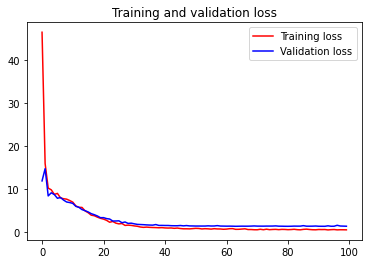

In [76]:
# plot loss curve on validation data
loss = classifier_fit.history['loss']
val_loss = classifier_fit.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss, 'r', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

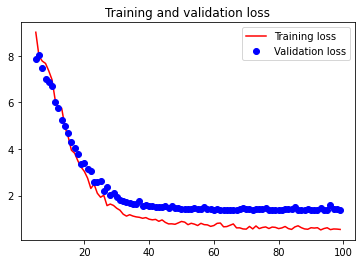

In [77]:
#due to the beginning loss too large,we plot again starting from index 5 epoch.
# plot loss curve on validation data
loss = classifier_fit.history['loss']
val_loss = classifier_fit.history['val_loss']

plt.figure()
plt.plot(range(5,len(loss)), loss[5:], 'r', label='Training loss')
plt.plot(range(5,len(val_loss)), val_loss[5:], 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Prediction

In [78]:
# predict
Y_predict = classifier.predict_proba(X_test)

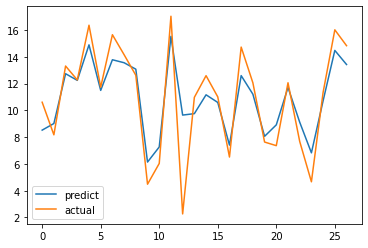

In [79]:
plt.plot(np.arange(len(Y_predict)),Y_predict,label = 'predict')
plt.plot(np.arange(len(Y_predict)),np.array(Y_test),label = 'actual')
plt.legend()
plt.show()

Mean Square Error = 3.5812539882545167
Correlation = 0.6759067731970033


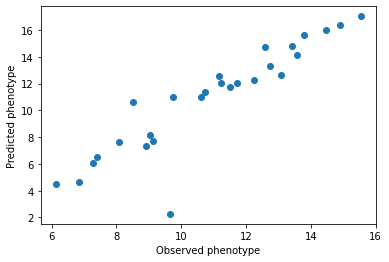

In [81]:
plt.xlabel('Observed phenotype')
plt.ylabel('Predicted phenotype')
plt.scatter(Y_predict,Y_test)
print(f"Mean Square Error = {mean_squared_error(Y_predict, Y_test)}")
print(f"Correlation = {math.sqrt(r2_score(Y_predict, Y_test))}")

### We could find that the prediction and the actual result almostly coincide. Moreover, the actual result is somewhat more radical than the prediction, which challenges us to predict.

# Make comparisons among different geno datasets

In [82]:
thresholds = ['1e-05','1e-04','0.001']
traits = ["Jmax25","Rdlight25","Resistwp25","WUEref","Av_Diameter_mm"]
loss_list = []
for threshold in thresholds:
    for trait in traits:
        print("threshold is",threshold,";trait is",trait,"\n");
        filename_geno = trait + "_" + threshold + ".geno"
        filename_pheno = "pheno_" + trait + "_" + threshold

        # load data
        genotype_file = '~/Poplar_GWAS/GS_method_compare/GS_geno_pheno/' + filename_geno
        genotype = pd.read_csv(genotype_file, sep='\t', index_col=0)
        print('genotype_file shape:', genotype.shape)

        genotype = genotype[genotype.columns[5:]].T
        genotype[genotype == '0/1'] = 0
        genotype[genotype == '1/0'] = 0
        genotype[genotype == '0/0'] = -1
        genotype[genotype == '1/1'] = 1

        # phenotype
        phenotype_file = '~/Poplar_GWAS/GS_method_compare/GS_geno_pheno/' + filename_pheno
        multi_pheno = pd.read_csv(phenotype_file, sep='\t', index_col=0)
        print('phenotype_multi shape:', multi_pheno.shape)

        X = genotype
        Y = multi_pheno.iloc[:, 0]

        # move the gene loci with NA traits
        X = X[~Y.isna()]
        Y = Y[~Y.isna()]

        if X.shape[0] != Y.shape[0]:
            print('Inconsistent data')

        X_onehot = to_categorical(X)

        X_onehot.shape

        # split df to train and valid
        X_train, X_test, Y_train, Y_test = train_test_split(
            X_onehot, Y, test_size=0.1)

        X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

        # split df to train and valid
        X_train, X_valid, Y_train, Y_valid = train_test_split(
            X_train, Y_train, test_size=0.1)

        X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

        # hyperparameters
        batch_size = 16
        learning_rate = 0.0001
        epochs = 100

        # conv 1D
        num_kernels = 16
        feature_size = X_train.shape[1]
        inChannel = 2
        kr = 1e-3
        drop_prec = 0.50

        classifier = Sequential()

        classifier.add(
            Conv1D(
                num_kernels,
                5,
                padding='same',
                activation='relu',
                kernel_regularizer=l1_l2(kr),
                input_shape=(feature_size, inChannel)))
        classifier.add(AveragePooling1D(pool_size=2))
        classifier.add(Dropout(drop_prec))

        classifier.add(Flatten())

        classifier.add(Dropout(drop_prec))
        classifier.add(Dense(1))

        #compile
        classifier.compile(
            loss='mean_squared_error',
            optimizer=tf.keras.optimizers.Adam(learning_rate),
            metrics=['acc'])

        #summary
        classifier.summary()
        
        classifier_fit = classifier.fit(
            X_train,
            Y_train,
            shuffle=True,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(X_valid, Y_valid),
            callbacks=[ModelCheckpoint]
        )
        val_loss = classifier_fit.history['val_loss']
        loss_list.append(val_loss[-1])

threshold is 1e-05 ;trait is Jmax25 

genotype_file shape: (234, 271)
phenotype_multi shape: (266, 1)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 234, 16)           176       
_________________________________________________________________
average_pooling1d_4 (Average (None, 117, 16)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 117, 16)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1872)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1872)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1873      
Total params: 2,04

14/14 [==============================] - 0s 3ms/step - loss: 4060.9026 - acc: 0.0000e+00 - val_loss: 3085.7834 - val_acc: 0.0000e+00
Epoch 24/100
14/14 [==============================] - 0s 3ms/step - loss: 3927.2896 - acc: 0.0000e+00 - val_loss: 2974.9817 - val_acc: 0.0000e+00
Epoch 25/100
14/14 [==============================] - 0s 3ms/step - loss: 3816.3491 - acc: 0.0000e+00 - val_loss: 2859.3105 - val_acc: 0.0000e+00
Epoch 26/100
14/14 [==============================] - 0s 3ms/step - loss: 3697.5010 - acc: 0.0000e+00 - val_loss: 2745.5012 - val_acc: 0.0000e+00
Epoch 27/100
14/14 [==============================] - 0s 3ms/step - loss: 3554.5171 - acc: 0.0000e+00 - val_loss: 2624.8301 - val_acc: 0.0000e+00
Epoch 28/100
14/14 [==============================] - 0s 3ms/step - loss: 3432.3782 - acc: 0.0000e+00 - val_loss: 2505.6367 - val_acc: 0.0000e+00
Epoch 29/100
14/14 [==============================] - 0s 3ms/step - loss: 3302.2849 - acc: 0.0000e+00 - val_loss: 2385.0312 - val_acc: 0.

14/14 [==============================] - 0s 3ms/step - loss: 1528.4337 - acc: 0.0000e+00 - val_loss: 971.9907 - val_acc: 0.0000e+00
Epoch 50/100
14/14 [==============================] - 0s 3ms/step - loss: 1481.5956 - acc: 0.0000e+00 - val_loss: 956.6111 - val_acc: 0.0000e+00
Epoch 51/100
14/14 [==============================] - 0s 3ms/step - loss: 1481.4963 - acc: 0.0000e+00 - val_loss: 946.8787 - val_acc: 0.0000e+00
Epoch 52/100
14/14 [==============================] - 0s 3ms/step - loss: 1474.8450 - acc: 0.0000e+00 - val_loss: 938.7542 - val_acc: 0.0000e+00
Epoch 53/100
14/14 [==============================] - 0s 3ms/step - loss: 1438.8092 - acc: 0.0000e+00 - val_loss: 931.6094 - val_acc: 0.0000e+00
Epoch 54/100
14/14 [==============================] - 0s 3ms/step - loss: 1467.5026 - acc: 0.0000e+00 - val_loss: 925.9490 - val_acc: 0.0000e+00
Epoch 55/100
14/14 [==============================] - 0s 3ms/step - loss: 1451.2256 - acc: 0.0000e+00 - val_loss: 922.4611 - val_acc: 0.0000e+0

14/14 [==============================] - 0s 3ms/step - loss: 1351.1815 - acc: 0.0000e+00 - val_loss: 916.2244 - val_acc: 0.0000e+00
Epoch 76/100
14/14 [==============================] - 0s 3ms/step - loss: 1328.0464 - acc: 0.0000e+00 - val_loss: 915.2139 - val_acc: 0.0000e+00
Epoch 77/100
14/14 [==============================] - 0s 3ms/step - loss: 1344.0337 - acc: 0.0000e+00 - val_loss: 915.8226 - val_acc: 0.0000e+00
Epoch 78/100
14/14 [==============================] - 0s 3ms/step - loss: 1372.3413 - acc: 0.0000e+00 - val_loss: 914.3945 - val_acc: 0.0000e+00
Epoch 79/100
14/14 [==============================] - 0s 3ms/step - loss: 1354.8439 - acc: 0.0000e+00 - val_loss: 912.7000 - val_acc: 0.0000e+00
Epoch 80/100
14/14 [==============================] - 0s 3ms/step - loss: 1349.5951 - acc: 0.0000e+00 - val_loss: 912.6848 - val_acc: 0.0000e+00
Epoch 81/100
14/14 [==============================] - 0s 3ms/step - loss: 1350.4995 - acc: 0.0000e+00 - val_loss: 911.7416 - val_acc: 0.0000e+0

Epoch 1/100
14/14 [==============================] - 0s 10ms/step - loss: 5.0117 - acc: 0.1157 - val_loss: 1.9025 - val_acc: 0.1600
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 4.2485 - acc: 0.1065 - val_loss: 1.5310 - val_acc: 0.1600
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 3.8386 - acc: 0.0926 - val_loss: 1.2772 - val_acc: 0.0400
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 3.4167 - acc: 0.0509 - val_loss: 1.1302 - val_acc: 0.0000e+00
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 2.8992 - acc: 0.0278 - val_loss: 1.0542 - val_acc: 0.0000e+00
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 3.0364 - acc: 0.0278 - val_loss: 1.0279 - val_acc: 0.0000e+00
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 2.7354 - acc: 0.0324 - val_loss: 1.0375 - val_acc: 0.0000e+00
Epoch 8/100
14/14 [==============================] - 0s 3ms/step -

14/14 [==============================] - 0s 3ms/step - loss: 2.3666 - acc: 0.0046 - val_loss: 1.1432 - val_acc: 0.0000e+00
Epoch 29/100
14/14 [==============================] - 0s 3ms/step - loss: 2.3295 - acc: 0.0000e+00 - val_loss: 1.1412 - val_acc: 0.0000e+00
Epoch 30/100
14/14 [==============================] - 0s 3ms/step - loss: 2.1842 - acc: 0.0000e+00 - val_loss: 1.1205 - val_acc: 0.0000e+00
Epoch 31/100
14/14 [==============================] - 0s 3ms/step - loss: 2.3856 - acc: 0.0000e+00 - val_loss: 1.1158 - val_acc: 0.0000e+00
Epoch 32/100
14/14 [==============================] - 0s 3ms/step - loss: 2.2693 - acc: 0.0046 - val_loss: 1.1243 - val_acc: 0.0000e+00
Epoch 33/100
14/14 [==============================] - 0s 3ms/step - loss: 2.4905 - acc: 0.0000e+00 - val_loss: 1.1197 - val_acc: 0.0000e+00
Epoch 34/100
14/14 [==============================] - 0s 3ms/step - loss: 2.3848 - acc: 0.0046 - val_loss: 1.1080 - val_acc: 0.0000e+00
Epoch 35/100
14/14 [=========================

Epoch 56/100
14/14 [==============================] - 0s 3ms/step - loss: 2.0313 - acc: 0.0093 - val_loss: 0.9887 - val_acc: 0.0000e+00
Epoch 57/100
14/14 [==============================] - 0s 3ms/step - loss: 2.0558 - acc: 0.0093 - val_loss: 0.9849 - val_acc: 0.0000e+00
Epoch 58/100
14/14 [==============================] - 0s 3ms/step - loss: 1.9641 - acc: 0.0000e+00 - val_loss: 0.9802 - val_acc: 0.0000e+00
Epoch 59/100
14/14 [==============================] - 0s 3ms/step - loss: 1.8854 - acc: 0.0000e+00 - val_loss: 0.9669 - val_acc: 0.0000e+00
Epoch 60/100
14/14 [==============================] - 0s 3ms/step - loss: 2.0914 - acc: 0.0000e+00 - val_loss: 0.9479 - val_acc: 0.0000e+00
Epoch 61/100
14/14 [==============================] - 0s 3ms/step - loss: 1.7746 - acc: 0.0046 - val_loss: 0.9513 - val_acc: 0.0000e+00
Epoch 62/100
14/14 [==============================] - 0s 3ms/step - loss: 1.8547 - acc: 0.0093 - val_loss: 0.9470 - val_acc: 0.0000e+00
Epoch 63/100
14/14 [================

14/14 [==============================] - 0s 3ms/step - loss: 1.6379 - acc: 0.0000e+00 - val_loss: 0.7870 - val_acc: 0.0000e+00
Epoch 84/100
14/14 [==============================] - 0s 3ms/step - loss: 1.6328 - acc: 0.0093 - val_loss: 0.7856 - val_acc: 0.0000e+00
Epoch 85/100
14/14 [==============================] - 0s 3ms/step - loss: 1.5494 - acc: 0.0000e+00 - val_loss: 0.7826 - val_acc: 0.0000e+00
Epoch 86/100
14/14 [==============================] - 0s 3ms/step - loss: 1.6095 - acc: 0.0093 - val_loss: 0.7813 - val_acc: 0.0000e+00
Epoch 87/100
14/14 [==============================] - 0s 3ms/step - loss: 1.6073 - acc: 0.0000e+00 - val_loss: 0.7666 - val_acc: 0.0000e+00
Epoch 88/100
14/14 [==============================] - 0s 3ms/step - loss: 1.5538 - acc: 0.0093 - val_loss: 0.7688 - val_acc: 0.0000e+00
Epoch 89/100
14/14 [==============================] - 0s 3ms/step - loss: 1.4873 - acc: 0.0139 - val_loss: 0.7747 - val_acc: 0.0000e+00
Epoch 90/100
14/14 [=============================

14/14 [==============================] - 0s 4ms/step - loss: 10.3743 - acc: 0.0000e+00 - val_loss: 5.8638 - val_acc: 0.0000e+00
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 10.5097 - acc: 0.0000e+00 - val_loss: 5.8940 - val_acc: 0.0000e+00
Epoch 8/100
14/14 [==============================] - 0s 4ms/step - loss: 9.5954 - acc: 0.0000e+00 - val_loss: 5.9238 - val_acc: 0.0000e+00
Epoch 9/100
14/14 [==============================] - 0s 4ms/step - loss: 10.0669 - acc: 0.0000e+00 - val_loss: 5.9330 - val_acc: 0.0000e+00
Epoch 10/100
14/14 [==============================] - 0s 4ms/step - loss: 9.7446 - acc: 0.0000e+00 - val_loss: 5.9341 - val_acc: 0.0000e+00
Epoch 11/100
14/14 [==============================] - 0s 4ms/step - loss: 9.6004 - acc: 0.0000e+00 - val_loss: 5.9565 - val_acc: 0.0000e+00
Epoch 12/100
14/14 [==============================] - 0s 4ms/step - loss: 9.7222 - acc: 0.0000e+00 - val_loss: 5.9290 - val_acc: 0.0000e+00
Epoch 13/100
14/14 [=============

Epoch 33/100
14/14 [==============================] - 0s 4ms/step - loss: 8.0791 - acc: 0.0000e+00 - val_loss: 5.4485 - val_acc: 0.0000e+00
Epoch 34/100
14/14 [==============================] - 0s 4ms/step - loss: 8.2586 - acc: 0.0000e+00 - val_loss: 5.4293 - val_acc: 0.0000e+00
Epoch 35/100
14/14 [==============================] - 0s 4ms/step - loss: 8.1992 - acc: 0.0000e+00 - val_loss: 5.4384 - val_acc: 0.0000e+00
Epoch 36/100
14/14 [==============================] - 0s 4ms/step - loss: 8.1495 - acc: 0.0000e+00 - val_loss: 5.4246 - val_acc: 0.0000e+00
Epoch 37/100
14/14 [==============================] - 0s 4ms/step - loss: 7.9109 - acc: 0.0000e+00 - val_loss: 5.4028 - val_acc: 0.0000e+00
Epoch 38/100
14/14 [==============================] - 0s 4ms/step - loss: 7.9858 - acc: 0.0000e+00 - val_loss: 5.3669 - val_acc: 0.0000e+00
Epoch 39/100
14/14 [==============================] - 0s 4ms/step - loss: 7.6550 - acc: 0.0000e+00 - val_loss: 5.2899 - val_acc: 0.0000e+00
Epoch 40/100
14/14 [

Epoch 60/100
14/14 [==============================] - 0s 4ms/step - loss: 6.3576 - acc: 0.0000e+00 - val_loss: 4.6735 - val_acc: 0.0000e+00
Epoch 61/100
14/14 [==============================] - 0s 4ms/step - loss: 6.2934 - acc: 0.0000e+00 - val_loss: 4.6546 - val_acc: 0.0000e+00
Epoch 62/100
14/14 [==============================] - 0s 4ms/step - loss: 6.0434 - acc: 0.0000e+00 - val_loss: 4.6477 - val_acc: 0.0000e+00
Epoch 63/100
14/14 [==============================] - 0s 4ms/step - loss: 6.2043 - acc: 0.0000e+00 - val_loss: 4.6084 - val_acc: 0.0000e+00
Epoch 64/100
14/14 [==============================] - 0s 4ms/step - loss: 6.1471 - acc: 0.0000e+00 - val_loss: 4.5827 - val_acc: 0.0000e+00
Epoch 65/100
14/14 [==============================] - 0s 4ms/step - loss: 6.1109 - acc: 0.0000e+00 - val_loss: 4.5692 - val_acc: 0.0000e+00
Epoch 66/100
14/14 [==============================] - 0s 4ms/step - loss: 5.7959 - acc: 0.0000e+00 - val_loss: 4.5331 - val_acc: 0.0000e+00
Epoch 67/100
14/14 [

14/14 [==============================] - 0s 4ms/step - loss: 4.7086 - acc: 0.0185 - val_loss: 4.2069 - val_acc: 0.0000e+00
Epoch 88/100
14/14 [==============================] - 0s 4ms/step - loss: 5.0243 - acc: 0.0046 - val_loss: 4.1922 - val_acc: 0.0000e+00
Epoch 89/100
14/14 [==============================] - 0s 4ms/step - loss: 4.7447 - acc: 0.0093 - val_loss: 4.1804 - val_acc: 0.0000e+00
Epoch 90/100
14/14 [==============================] - 0s 4ms/step - loss: 4.8965 - acc: 0.0185 - val_loss: 4.1693 - val_acc: 0.0000e+00
Epoch 91/100
14/14 [==============================] - 0s 4ms/step - loss: 4.5187 - acc: 0.0139 - val_loss: 4.1506 - val_acc: 0.0000e+00
Epoch 92/100
14/14 [==============================] - 0s 4ms/step - loss: 4.9781 - acc: 0.0093 - val_loss: 4.1379 - val_acc: 0.0000e+00
Epoch 93/100
14/14 [==============================] - 0s 4ms/step - loss: 4.8091 - acc: 0.0185 - val_loss: 4.1335 - val_acc: 0.0000e+00
Epoch 94/100
14/14 [==============================] - 0s 4ms/

14/14 [==============================] - 0s 5ms/step - loss: 11.6625 - acc: 0.0000e+00 - val_loss: 5.9564 - val_acc: 0.0000e+00
Epoch 11/100
14/14 [==============================] - 0s 4ms/step - loss: 11.1090 - acc: 0.0000e+00 - val_loss: 5.7869 - val_acc: 0.0000e+00
Epoch 12/100
14/14 [==============================] - 0s 4ms/step - loss: 11.1429 - acc: 0.0000e+00 - val_loss: 5.7145 - val_acc: 0.0000e+00
Epoch 13/100
14/14 [==============================] - 0s 5ms/step - loss: 11.2234 - acc: 0.0000e+00 - val_loss: 5.7013 - val_acc: 0.0000e+00
Epoch 14/100
14/14 [==============================] - 0s 4ms/step - loss: 11.3849 - acc: 0.0000e+00 - val_loss: 5.6531 - val_acc: 0.0000e+00
Epoch 15/100
14/14 [==============================] - 0s 5ms/step - loss: 11.0254 - acc: 0.0000e+00 - val_loss: 5.6192 - val_acc: 0.0000e+00
Epoch 16/100
14/14 [==============================] - 0s 4ms/step - loss: 10.9185 - acc: 0.0000e+00 - val_loss: 5.6077 - val_acc: 0.0000e+00
Epoch 17/100
14/14 [======

Epoch 37/100
14/14 [==============================] - 0s 4ms/step - loss: 10.7277 - acc: 0.0000e+00 - val_loss: 5.3336 - val_acc: 0.0000e+00
Epoch 38/100
14/14 [==============================] - 0s 4ms/step - loss: 10.1482 - acc: 0.0000e+00 - val_loss: 5.3242 - val_acc: 0.0000e+00
Epoch 39/100
14/14 [==============================] - 0s 4ms/step - loss: 10.8475 - acc: 0.0000e+00 - val_loss: 5.3183 - val_acc: 0.0000e+00
Epoch 40/100
14/14 [==============================] - 0s 4ms/step - loss: 10.4279 - acc: 0.0000e+00 - val_loss: 5.3152 - val_acc: 0.0000e+00
Epoch 41/100
14/14 [==============================] - 0s 4ms/step - loss: 10.5899 - acc: 0.0000e+00 - val_loss: 5.2999 - val_acc: 0.0000e+00
Epoch 42/100
14/14 [==============================] - 0s 4ms/step - loss: 10.3334 - acc: 0.0000e+00 - val_loss: 5.2932 - val_acc: 0.0000e+00
Epoch 43/100
14/14 [==============================] - 0s 4ms/step - loss: 10.1724 - acc: 0.0000e+00 - val_loss: 5.2723 - val_acc: 0.0000e+00
Epoch 44/100


Epoch 64/100
14/14 [==============================] - 0s 4ms/step - loss: 9.7591 - acc: 0.0000e+00 - val_loss: 5.0299 - val_acc: 0.0000e+00
Epoch 65/100
14/14 [==============================] - 0s 4ms/step - loss: 9.6680 - acc: 0.0000e+00 - val_loss: 5.0156 - val_acc: 0.0000e+00
Epoch 66/100
14/14 [==============================] - 0s 5ms/step - loss: 9.6648 - acc: 0.0000e+00 - val_loss: 5.0003 - val_acc: 0.0000e+00
Epoch 67/100
14/14 [==============================] - 0s 4ms/step - loss: 9.9993 - acc: 0.0000e+00 - val_loss: 4.9890 - val_acc: 0.0000e+00
Epoch 68/100
14/14 [==============================] - 0s 4ms/step - loss: 9.2470 - acc: 0.0000e+00 - val_loss: 4.9754 - val_acc: 0.0000e+00
Epoch 69/100
14/14 [==============================] - 0s 4ms/step - loss: 9.6894 - acc: 0.0000e+00 - val_loss: 4.9609 - val_acc: 0.0000e+00
Epoch 70/100
14/14 [==============================] - 0s 4ms/step - loss: 9.3481 - acc: 0.0000e+00 - val_loss: 4.9487 - val_acc: 0.0000e+00
Epoch 71/100
14/14 [

Epoch 91/100
14/14 [==============================] - 0s 4ms/step - loss: 8.5728 - acc: 0.0000e+00 - val_loss: 4.6111 - val_acc: 0.0000e+00
Epoch 92/100
14/14 [==============================] - 0s 4ms/step - loss: 8.5518 - acc: 0.0000e+00 - val_loss: 4.5988 - val_acc: 0.0000e+00
Epoch 93/100
14/14 [==============================] - 0s 4ms/step - loss: 8.8181 - acc: 0.0000e+00 - val_loss: 4.5864 - val_acc: 0.0000e+00
Epoch 94/100
14/14 [==============================] - 0s 4ms/step - loss: 8.7732 - acc: 0.0000e+00 - val_loss: 4.5723 - val_acc: 0.0000e+00
Epoch 95/100
14/14 [==============================] - 0s 4ms/step - loss: 8.5627 - acc: 0.0000e+00 - val_loss: 4.5548 - val_acc: 0.0000e+00
Epoch 96/100
14/14 [==============================] - 0s 4ms/step - loss: 8.3553 - acc: 0.0000e+00 - val_loss: 4.5453 - val_acc: 0.0000e+00
Epoch 97/100
14/14 [==============================] - 0s 4ms/step - loss: 8.6918 - acc: 0.0000e+00 - val_loss: 4.5350 - val_acc: 0.0000e+00
Epoch 98/100
14/14 [

Epoch 14/100
14/14 [==============================] - 0s 2ms/step - loss: 98.2842 - acc: 0.0000e+00 - val_loss: 78.9782 - val_acc: 0.0000e+00
Epoch 15/100
14/14 [==============================] - 0s 2ms/step - loss: 96.8045 - acc: 0.0000e+00 - val_loss: 76.1936 - val_acc: 0.0000e+00
Epoch 16/100
14/14 [==============================] - 0s 2ms/step - loss: 91.1177 - acc: 0.0000e+00 - val_loss: 73.3363 - val_acc: 0.0000e+00
Epoch 17/100
14/14 [==============================] - 0s 2ms/step - loss: 88.6179 - acc: 0.0000e+00 - val_loss: 70.3624 - val_acc: 0.0000e+00
Epoch 18/100
14/14 [==============================] - 0s 2ms/step - loss: 84.6094 - acc: 0.0000e+00 - val_loss: 67.3053 - val_acc: 0.0000e+00
Epoch 19/100
14/14 [==============================] - 0s 2ms/step - loss: 82.8885 - acc: 0.0000e+00 - val_loss: 64.1500 - val_acc: 0.0000e+00
Epoch 20/100
14/14 [==============================] - 0s 2ms/step - loss: 78.7861 - acc: 0.0000e+00 - val_loss: 60.9698 - val_acc: 0.0000e+00
Epoch 

Epoch 41/100
14/14 [==============================] - 0s 2ms/step - loss: 16.5627 - acc: 0.0000e+00 - val_loss: 12.9092 - val_acc: 0.0000e+00
Epoch 42/100
14/14 [==============================] - 0s 2ms/step - loss: 16.1872 - acc: 0.0000e+00 - val_loss: 12.5134 - val_acc: 0.0000e+00
Epoch 43/100
14/14 [==============================] - 0s 2ms/step - loss: 15.5609 - acc: 0.0000e+00 - val_loss: 12.2363 - val_acc: 0.0000e+00
Epoch 44/100
14/14 [==============================] - 0s 2ms/step - loss: 14.2270 - acc: 0.0000e+00 - val_loss: 12.0730 - val_acc: 0.0000e+00
Epoch 45/100
14/14 [==============================] - 0s 2ms/step - loss: 15.1621 - acc: 0.0000e+00 - val_loss: 11.9834 - val_acc: 0.0000e+00
Epoch 46/100
14/14 [==============================] - 0s 2ms/step - loss: 13.7445 - acc: 0.0000e+00 - val_loss: 11.9660 - val_acc: 0.0000e+00
Epoch 47/100
14/14 [==============================] - 0s 2ms/step - loss: 13.5777 - acc: 0.0000e+00 - val_loss: 11.9980 - val_acc: 0.0000e+00
Epoch 

Epoch 68/100
14/14 [==============================] - 0s 2ms/step - loss: 13.2493 - acc: 0.0000e+00 - val_loss: 12.5898 - val_acc: 0.0000e+00
Epoch 69/100
14/14 [==============================] - 0s 2ms/step - loss: 12.8163 - acc: 0.0000e+00 - val_loss: 12.5866 - val_acc: 0.0000e+00
Epoch 70/100
14/14 [==============================] - 0s 2ms/step - loss: 12.2929 - acc: 0.0000e+00 - val_loss: 12.6337 - val_acc: 0.0000e+00
Epoch 71/100
14/14 [==============================] - 0s 2ms/step - loss: 12.6801 - acc: 0.0000e+00 - val_loss: 12.7268 - val_acc: 0.0000e+00
Epoch 72/100
14/14 [==============================] - 0s 2ms/step - loss: 12.1044 - acc: 0.0000e+00 - val_loss: 12.6740 - val_acc: 0.0000e+00
Epoch 73/100
14/14 [==============================] - 0s 2ms/step - loss: 11.1933 - acc: 0.0000e+00 - val_loss: 12.5878 - val_acc: 0.0000e+00
Epoch 74/100
14/14 [==============================] - 0s 2ms/step - loss: 10.4510 - acc: 0.0000e+00 - val_loss: 12.5727 - val_acc: 0.0000e+00
Epoch 

Epoch 95/100
14/14 [==============================] - 0s 2ms/step - loss: 12.7986 - acc: 0.0000e+00 - val_loss: 11.8848 - val_acc: 0.0000e+00
Epoch 96/100
14/14 [==============================] - 0s 2ms/step - loss: 12.7887 - acc: 0.0000e+00 - val_loss: 11.8596 - val_acc: 0.0000e+00
Epoch 97/100
14/14 [==============================] - 0s 2ms/step - loss: 11.6556 - acc: 0.0000e+00 - val_loss: 11.7485 - val_acc: 0.0000e+00
Epoch 98/100
14/14 [==============================] - 0s 2ms/step - loss: 13.2861 - acc: 0.0000e+00 - val_loss: 11.7509 - val_acc: 0.0000e+00
Epoch 99/100
14/14 [==============================] - 0s 2ms/step - loss: 12.3231 - acc: 0.0000e+00 - val_loss: 11.7747 - val_acc: 0.0000e+00
Epoch 100/100
14/14 [==============================] - 0s 2ms/step - loss: 13.2125 - acc: 0.0000e+00 - val_loss: 11.7567 - val_acc: 0.0000e+00
threshold is 1e-04 ;trait is Jmax25 

genotype_file shape: (1380, 271)
phenotype_multi shape: (266, 1)
Model: "sequential_9"
______________________

14/14 [==============================] - 0s 6ms/step - loss: 1920.3499 - acc: 0.0000e+00 - val_loss: 1341.2653 - val_acc: 0.0000e+00
Epoch 18/100
14/14 [==============================] - 0s 6ms/step - loss: 1801.5665 - acc: 0.0000e+00 - val_loss: 1245.7467 - val_acc: 0.0000e+00
Epoch 19/100
14/14 [==============================] - 0s 6ms/step - loss: 1707.9985 - acc: 0.0000e+00 - val_loss: 1184.9335 - val_acc: 0.0000e+00
Epoch 20/100
14/14 [==============================] - 0s 6ms/step - loss: 1651.2875 - acc: 0.0000e+00 - val_loss: 1139.3433 - val_acc: 0.0000e+00
Epoch 21/100
14/14 [==============================] - 0s 6ms/step - loss: 1604.6891 - acc: 0.0000e+00 - val_loss: 1106.7374 - val_acc: 0.0000e+00
Epoch 22/100
14/14 [==============================] - 0s 6ms/step - loss: 1563.6411 - acc: 0.0000e+00 - val_loss: 1086.2241 - val_acc: 0.0000e+00
Epoch 23/100
14/14 [==============================] - 0s 6ms/step - loss: 1559.5292 - acc: 0.0000e+00 - val_loss: 1071.0499 - val_acc: 0.

Epoch 44/100
14/14 [==============================] - 0s 6ms/step - loss: 1403.4388 - acc: 0.0000e+00 - val_loss: 996.1421 - val_acc: 0.0000e+00
Epoch 45/100
14/14 [==============================] - 0s 6ms/step - loss: 1404.6173 - acc: 0.0000e+00 - val_loss: 992.9360 - val_acc: 0.0000e+00
Epoch 46/100
14/14 [==============================] - 0s 6ms/step - loss: 1393.9475 - acc: 0.0000e+00 - val_loss: 990.0400 - val_acc: 0.0000e+00
Epoch 47/100
14/14 [==============================] - 0s 6ms/step - loss: 1402.1393 - acc: 0.0000e+00 - val_loss: 987.0425 - val_acc: 0.0000e+00
Epoch 48/100
14/14 [==============================] - 0s 6ms/step - loss: 1394.4689 - acc: 0.0000e+00 - val_loss: 983.6786 - val_acc: 0.0000e+00
Epoch 49/100
14/14 [==============================] - 0s 6ms/step - loss: 1368.2111 - acc: 0.0000e+00 - val_loss: 980.6614 - val_acc: 0.0000e+00
Epoch 50/100
14/14 [==============================] - 0s 6ms/step - loss: 1370.8547 - acc: 0.0000e+00 - val_loss: 977.1631 - val_a

14/14 [==============================] - 0s 6ms/step - loss: 1265.3234 - acc: 0.0000e+00 - val_loss: 912.1031 - val_acc: 0.0000e+00
Epoch 71/100
14/14 [==============================] - 0s 6ms/step - loss: 1239.6515 - acc: 0.0000e+00 - val_loss: 908.1154 - val_acc: 0.0000e+00
Epoch 72/100
14/14 [==============================] - 0s 6ms/step - loss: 1233.0790 - acc: 0.0000e+00 - val_loss: 904.4925 - val_acc: 0.0000e+00
Epoch 73/100
14/14 [==============================] - 0s 6ms/step - loss: 1248.5402 - acc: 0.0000e+00 - val_loss: 901.3918 - val_acc: 0.0000e+00
Epoch 74/100
14/14 [==============================] - 0s 6ms/step - loss: 1219.5732 - acc: 0.0000e+00 - val_loss: 897.8080 - val_acc: 0.0000e+00
Epoch 75/100
14/14 [==============================] - 0s 6ms/step - loss: 1218.8229 - acc: 0.0000e+00 - val_loss: 894.5201 - val_acc: 0.0000e+00
Epoch 76/100
14/14 [==============================] - 0s 6ms/step - loss: 1211.6832 - acc: 0.0000e+00 - val_loss: 891.8628 - val_acc: 0.0000e+0

14/14 [==============================] - 0s 6ms/step - loss: 1089.0297 - acc: 0.0000e+00 - val_loss: 824.2103 - val_acc: 0.0000e+00
Epoch 97/100
14/14 [==============================] - 0s 6ms/step - loss: 1077.6644 - acc: 0.0000e+00 - val_loss: 820.7205 - val_acc: 0.0000e+00
Epoch 98/100
14/14 [==============================] - 0s 6ms/step - loss: 1069.9143 - acc: 0.0000e+00 - val_loss: 817.0247 - val_acc: 0.0000e+00
Epoch 99/100
14/14 [==============================] - 0s 6ms/step - loss: 1052.6056 - acc: 0.0000e+00 - val_loss: 813.7665 - val_acc: 0.0000e+00
Epoch 100/100
14/14 [==============================] - 0s 6ms/step - loss: 1041.0000 - acc: 0.0000e+00 - val_loss: 809.9666 - val_acc: 0.0000e+00
threshold is 1e-04 ;trait is Rdlight25 

genotype_file shape: (1147, 273)
phenotype_multi shape: (268, 1)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)        

Epoch 19/100
14/14 [==============================] - 0s 6ms/step - loss: 1.7038 - acc: 0.0231 - val_loss: 0.6061 - val_acc: 0.0000e+00
Epoch 20/100
14/14 [==============================] - 0s 6ms/step - loss: 1.5663 - acc: 0.0185 - val_loss: 0.5785 - val_acc: 0.0000e+00
Epoch 21/100
14/14 [==============================] - 0s 6ms/step - loss: 1.7279 - acc: 0.0185 - val_loss: 0.5614 - val_acc: 0.0000e+00
Epoch 22/100
14/14 [==============================] - 0s 6ms/step - loss: 1.6749 - acc: 0.0231 - val_loss: 0.5566 - val_acc: 0.0000e+00
Epoch 23/100
14/14 [==============================] - 0s 6ms/step - loss: 1.6144 - acc: 0.0139 - val_loss: 0.5602 - val_acc: 0.0000e+00
Epoch 24/100
14/14 [==============================] - 0s 6ms/step - loss: 1.5469 - acc: 0.0278 - val_loss: 0.5181 - val_acc: 0.0000e+00
Epoch 25/100
14/14 [==============================] - 0s 6ms/step - loss: 1.6172 - acc: 0.0278 - val_loss: 0.5135 - val_acc: 0.0000e+00
Epoch 26/100
14/14 [============================

14/14 [==============================] - 0s 6ms/step - loss: 1.0111 - acc: 0.0417 - val_loss: 0.3233 - val_acc: 0.0800
Epoch 47/100
14/14 [==============================] - 0s 6ms/step - loss: 0.8590 - acc: 0.0833 - val_loss: 0.3183 - val_acc: 0.0400
Epoch 48/100
14/14 [==============================] - 0s 6ms/step - loss: 0.9495 - acc: 0.0370 - val_loss: 0.3227 - val_acc: 0.0400
Epoch 49/100
14/14 [==============================] - 0s 6ms/step - loss: 0.9926 - acc: 0.0417 - val_loss: 0.3072 - val_acc: 0.0800
Epoch 50/100
14/14 [==============================] - 0s 6ms/step - loss: 0.9141 - acc: 0.0602 - val_loss: 0.3063 - val_acc: 0.0800
Epoch 51/100
14/14 [==============================] - 0s 6ms/step - loss: 0.8675 - acc: 0.0509 - val_loss: 0.3263 - val_acc: 0.0400
Epoch 52/100
14/14 [==============================] - 0s 6ms/step - loss: 0.8369 - acc: 0.0370 - val_loss: 0.3069 - val_acc: 0.0400
Epoch 53/100
14/14 [==============================] - 0s 6ms/step - loss: 0.8636 - acc: 0

14/14 [==============================] - 0s 6ms/step - loss: 0.6555 - acc: 0.0648 - val_loss: 0.2846 - val_acc: 0.0400
Epoch 75/100
14/14 [==============================] - 0s 6ms/step - loss: 0.7857 - acc: 0.0463 - val_loss: 0.2703 - val_acc: 0.0800
Epoch 76/100
14/14 [==============================] - 0s 6ms/step - loss: 0.6303 - acc: 0.0694 - val_loss: 0.2689 - val_acc: 0.0800
Epoch 77/100
14/14 [==============================] - 0s 6ms/step - loss: 0.6464 - acc: 0.0694 - val_loss: 0.2709 - val_acc: 0.0400
Epoch 78/100
14/14 [==============================] - 0s 6ms/step - loss: 0.6207 - acc: 0.0648 - val_loss: 0.2749 - val_acc: 0.0400
Epoch 79/100
14/14 [==============================] - 0s 6ms/step - loss: 0.6048 - acc: 0.0787 - val_loss: 0.2741 - val_acc: 0.0400
Epoch 80/100
14/14 [==============================] - 0s 6ms/step - loss: 0.5724 - acc: 0.0602 - val_loss: 0.2715 - val_acc: 0.0400
Epoch 81/100
14/14 [==============================] - 0s 6ms/step - loss: 0.5892 - acc: 0

14/14 [==============================] - 0s 13ms/step - loss: 10.0138 - acc: 0.0046 - val_loss: 7.6244 - val_acc: 0.0000e+00
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: 8.7850 - acc: 0.0000e+00 - val_loss: 6.9436 - val_acc: 0.0000e+00
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 8.2747 - acc: 0.0046 - val_loss: 6.4894 - val_acc: 0.0000e+00
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 8.0318 - acc: 0.0000e+00 - val_loss: 6.4169 - val_acc: 0.0000e+00
Epoch 5/100
14/14 [==============================] - 0s 7ms/step - loss: 7.9718 - acc: 0.0000e+00 - val_loss: 6.6425 - val_acc: 0.0000e+00
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: 7.6111 - acc: 0.0000e+00 - val_loss: 6.1580 - val_acc: 0.0000e+00
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 7.6493 - acc: 0.0046 - val_loss: 6.0586 - val_acc: 0.0000e+00
Epoch 8/100
14/14 [==============================

14/14 [==============================] - 0s 7ms/step - loss: 4.9256 - acc: 0.0000e+00 - val_loss: 4.2006 - val_acc: 0.0000e+00
Epoch 29/100
14/14 [==============================] - 0s 7ms/step - loss: 4.2257 - acc: 0.0000e+00 - val_loss: 3.9800 - val_acc: 0.0000e+00
Epoch 30/100
14/14 [==============================] - 0s 7ms/step - loss: 4.6981 - acc: 0.0046 - val_loss: 3.8878 - val_acc: 0.0000e+00
Epoch 31/100
14/14 [==============================] - 0s 7ms/step - loss: 4.1935 - acc: 0.0046 - val_loss: 3.8782 - val_acc: 0.0000e+00
Epoch 32/100
14/14 [==============================] - 0s 7ms/step - loss: 4.5190 - acc: 0.0093 - val_loss: 3.8343 - val_acc: 0.0000e+00
Epoch 33/100
14/14 [==============================] - 0s 6ms/step - loss: 4.1726 - acc: 0.0046 - val_loss: 3.8113 - val_acc: 0.0000e+00
Epoch 34/100
14/14 [==============================] - 0s 7ms/step - loss: 4.0222 - acc: 0.0185 - val_loss: 3.6828 - val_acc: 0.0400
Epoch 35/100
14/14 [==============================] - 0s 

Epoch 56/100
14/14 [==============================] - 0s 7ms/step - loss: 3.1995 - acc: 0.0324 - val_loss: 3.0497 - val_acc: 0.0800
Epoch 57/100
14/14 [==============================] - 0s 7ms/step - loss: 3.3251 - acc: 0.0463 - val_loss: 3.0353 - val_acc: 0.0800
Epoch 58/100
14/14 [==============================] - 0s 7ms/step - loss: 3.1621 - acc: 0.0231 - val_loss: 3.0594 - val_acc: 0.0800
Epoch 59/100
14/14 [==============================] - 0s 7ms/step - loss: 2.9663 - acc: 0.0093 - val_loss: 3.0264 - val_acc: 0.0800
Epoch 60/100
14/14 [==============================] - 0s 7ms/step - loss: 2.8913 - acc: 0.0185 - val_loss: 2.9815 - val_acc: 0.0800
Epoch 61/100
14/14 [==============================] - 0s 7ms/step - loss: 3.0552 - acc: 0.0185 - val_loss: 2.9985 - val_acc: 0.0800
Epoch 62/100
14/14 [==============================] - 0s 7ms/step - loss: 2.7940 - acc: 0.0278 - val_loss: 2.9750 - val_acc: 0.0800
Epoch 63/100
14/14 [==============================] - 0s 7ms/step - loss: 2.

Epoch 84/100
14/14 [==============================] - 0s 7ms/step - loss: 2.3802 - acc: 0.0185 - val_loss: 2.7563 - val_acc: 0.0800
Epoch 85/100
14/14 [==============================] - 0s 7ms/step - loss: 2.4478 - acc: 0.0417 - val_loss: 2.7703 - val_acc: 0.0800
Epoch 86/100
14/14 [==============================] - 0s 7ms/step - loss: 2.1719 - acc: 0.0370 - val_loss: 2.7844 - val_acc: 0.0800
Epoch 87/100
14/14 [==============================] - 0s 7ms/step - loss: 2.3785 - acc: 0.0370 - val_loss: 2.7317 - val_acc: 0.1200
Epoch 88/100
14/14 [==============================] - 0s 7ms/step - loss: 2.1814 - acc: 0.0278 - val_loss: 2.8126 - val_acc: 0.0800
Epoch 89/100
14/14 [==============================] - 0s 7ms/step - loss: 2.1863 - acc: 0.0417 - val_loss: 2.7350 - val_acc: 0.1200
Epoch 90/100
14/14 [==============================] - 0s 7ms/step - loss: 2.3778 - acc: 0.0370 - val_loss: 2.7473 - val_acc: 0.1200
Epoch 91/100
14/14 [==============================] - 0s 7ms/step - loss: 2.

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


phenotype_multi shape: (268, 1)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 3446, 16)          176       
_________________________________________________________________
average_pooling1d_12 (Averag (None, 1723, 16)          0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 1723, 16)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 27568)             0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 27568)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 27569     
Total params: 27,745
Trainable params: 27,745
Non-trainable params: 0
_________________

Epoch 24/100
14/14 [==============================] - 0s 9ms/step - loss: 6.2860 - acc: 0.0000e+00 - val_loss: 30.5220 - val_acc: 0.0000e+00
Epoch 25/100
14/14 [==============================] - 0s 8ms/step - loss: 6.2319 - acc: 0.0000e+00 - val_loss: 30.0036 - val_acc: 0.0000e+00
Epoch 26/100
14/14 [==============================] - 0s 9ms/step - loss: 6.3166 - acc: 0.0000e+00 - val_loss: 30.9624 - val_acc: 0.0000e+00
Epoch 27/100
14/14 [==============================] - 0s 9ms/step - loss: 6.0570 - acc: 0.0000e+00 - val_loss: 29.3369 - val_acc: 0.0000e+00
Epoch 28/100
14/14 [==============================] - 0s 8ms/step - loss: 5.8423 - acc: 0.0000e+00 - val_loss: 29.1800 - val_acc: 0.0000e+00
Epoch 29/100
14/14 [==============================] - 0s 9ms/step - loss: 5.8011 - acc: 0.0000e+00 - val_loss: 28.3130 - val_acc: 0.0000e+00
Epoch 30/100
14/14 [==============================] - 0s 9ms/step - loss: 5.5102 - acc: 0.0000e+00 - val_loss: 28.0029 - val_acc: 0.0000e+00
Epoch 31/100


Epoch 51/100
14/14 [==============================] - 0s 9ms/step - loss: 2.9212 - acc: 0.0000e+00 - val_loss: 20.5773 - val_acc: 0.0000e+00
Epoch 52/100
14/14 [==============================] - 0s 8ms/step - loss: 2.8386 - acc: 0.0000e+00 - val_loss: 20.8137 - val_acc: 0.0000e+00
Epoch 53/100
14/14 [==============================] - 0s 8ms/step - loss: 2.7677 - acc: 0.0000e+00 - val_loss: 19.8705 - val_acc: 0.0000e+00
Epoch 54/100
14/14 [==============================] - 0s 8ms/step - loss: 2.6964 - acc: 0.0000e+00 - val_loss: 19.4092 - val_acc: 0.0000e+00
Epoch 55/100
14/14 [==============================] - 0s 8ms/step - loss: 2.3355 - acc: 0.0000e+00 - val_loss: 18.8415 - val_acc: 0.0000e+00
Epoch 56/100
14/14 [==============================] - 0s 9ms/step - loss: 2.2737 - acc: 0.0000e+00 - val_loss: 19.7384 - val_acc: 0.0000e+00
Epoch 57/100
14/14 [==============================] - 0s 8ms/step - loss: 2.1519 - acc: 0.0000e+00 - val_loss: 18.5060 - val_acc: 0.0000e+00
Epoch 58/100


Epoch 78/100
14/14 [==============================] - 0s 9ms/step - loss: 1.5459 - acc: 0.0000e+00 - val_loss: 15.8462 - val_acc: 0.0000e+00
Epoch 79/100
14/14 [==============================] - 0s 9ms/step - loss: 1.5366 - acc: 0.0000e+00 - val_loss: 15.5775 - val_acc: 0.0000e+00
Epoch 80/100
14/14 [==============================] - 0s 8ms/step - loss: 1.3340 - acc: 0.0000e+00 - val_loss: 15.8944 - val_acc: 0.0000e+00
Epoch 81/100
14/14 [==============================] - 0s 8ms/step - loss: 1.5677 - acc: 0.0000e+00 - val_loss: 15.9347 - val_acc: 0.0000e+00
Epoch 82/100
14/14 [==============================] - 0s 9ms/step - loss: 1.3788 - acc: 0.0000e+00 - val_loss: 15.7138 - val_acc: 0.0000e+00
Epoch 83/100
14/14 [==============================] - 0s 8ms/step - loss: 1.2592 - acc: 0.0000e+00 - val_loss: 15.7182 - val_acc: 0.0000e+00
Epoch 84/100
14/14 [==============================] - 0s 9ms/step - loss: 1.3811 - acc: 0.0000e+00 - val_loss: 15.8716 - val_acc: 0.0000e+00
Epoch 85/100


Epoch 1/100
14/14 [==============================] - 0s 12ms/step - loss: 100.8069 - acc: 0.0000e+00 - val_loss: 79.7350 - val_acc: 0.0000e+00
Epoch 2/100
14/14 [==============================] - 0s 5ms/step - loss: 79.8062 - acc: 0.0000e+00 - val_loss: 61.7967 - val_acc: 0.0000e+00
Epoch 3/100
14/14 [==============================] - 0s 5ms/step - loss: 60.9347 - acc: 0.0000e+00 - val_loss: 46.7981 - val_acc: 0.0000e+00
Epoch 4/100
14/14 [==============================] - 0s 5ms/step - loss: 44.8196 - acc: 0.0000e+00 - val_loss: 34.8428 - val_acc: 0.0000e+00
Epoch 5/100
14/14 [==============================] - 0s 5ms/step - loss: 32.4281 - acc: 0.0000e+00 - val_loss: 26.0095 - val_acc: 0.0000e+00
Epoch 6/100
14/14 [==============================] - 0s 5ms/step - loss: 23.9147 - acc: 0.0000e+00 - val_loss: 20.3527 - val_acc: 0.0000e+00
Epoch 7/100
14/14 [==============================] - 0s 5ms/step - loss: 16.7045 - acc: 0.0000e+00 - val_loss: 17.4193 - val_acc: 0.0000e+00
Epoch 8/100

Epoch 28/100
14/14 [==============================] - 0s 5ms/step - loss: 9.4016 - acc: 0.0000e+00 - val_loss: 15.2615 - val_acc: 0.0000e+00
Epoch 29/100
14/14 [==============================] - 0s 5ms/step - loss: 9.5656 - acc: 0.0000e+00 - val_loss: 15.2660 - val_acc: 0.0000e+00
Epoch 30/100
14/14 [==============================] - 0s 5ms/step - loss: 8.9420 - acc: 0.0000e+00 - val_loss: 15.1710 - val_acc: 0.0000e+00
Epoch 31/100
14/14 [==============================] - 0s 5ms/step - loss: 9.2400 - acc: 0.0000e+00 - val_loss: 14.8914 - val_acc: 0.0000e+00
Epoch 32/100
14/14 [==============================] - 0s 5ms/step - loss: 8.5615 - acc: 0.0000e+00 - val_loss: 14.8807 - val_acc: 0.0000e+00
Epoch 33/100
14/14 [==============================] - 0s 5ms/step - loss: 8.3655 - acc: 0.0000e+00 - val_loss: 14.9034 - val_acc: 0.0000e+00
Epoch 34/100
14/14 [==============================] - 0s 5ms/step - loss: 8.6190 - acc: 0.0000e+00 - val_loss: 14.8734 - val_acc: 0.0000e+00
Epoch 35/100


Epoch 55/100
14/14 [==============================] - 0s 5ms/step - loss: 6.6716 - acc: 0.0000e+00 - val_loss: 13.1363 - val_acc: 0.0000e+00
Epoch 56/100
14/14 [==============================] - 0s 5ms/step - loss: 6.7451 - acc: 0.0000e+00 - val_loss: 12.9766 - val_acc: 0.0000e+00
Epoch 57/100
14/14 [==============================] - 0s 5ms/step - loss: 6.5341 - acc: 0.0000e+00 - val_loss: 13.0256 - val_acc: 0.0000e+00
Epoch 58/100
14/14 [==============================] - 0s 5ms/step - loss: 5.9070 - acc: 0.0000e+00 - val_loss: 12.8475 - val_acc: 0.0000e+00
Epoch 59/100
14/14 [==============================] - 0s 5ms/step - loss: 6.1848 - acc: 0.0000e+00 - val_loss: 12.7559 - val_acc: 0.0000e+00
Epoch 60/100
14/14 [==============================] - 0s 5ms/step - loss: 5.7896 - acc: 0.0000e+00 - val_loss: 12.7966 - val_acc: 0.0000e+00
Epoch 61/100
14/14 [==============================] - 0s 5ms/step - loss: 5.3687 - acc: 0.0000e+00 - val_loss: 12.7115 - val_acc: 0.0000e+00
Epoch 62/100


Epoch 82/100
14/14 [==============================] - 0s 5ms/step - loss: 3.8105 - acc: 0.0000e+00 - val_loss: 10.7716 - val_acc: 0.0000e+00
Epoch 83/100
14/14 [==============================] - 0s 5ms/step - loss: 4.0176 - acc: 0.0000e+00 - val_loss: 10.6614 - val_acc: 0.0000e+00
Epoch 84/100
14/14 [==============================] - 0s 5ms/step - loss: 4.3338 - acc: 0.0000e+00 - val_loss: 10.5741 - val_acc: 0.0000e+00
Epoch 85/100
14/14 [==============================] - 0s 5ms/step - loss: 4.2695 - acc: 0.0000e+00 - val_loss: 10.5141 - val_acc: 0.0000e+00
Epoch 86/100
14/14 [==============================] - 0s 5ms/step - loss: 3.9798 - acc: 0.0000e+00 - val_loss: 10.3763 - val_acc: 0.0000e+00
Epoch 87/100
14/14 [==============================] - 0s 5ms/step - loss: 3.9308 - acc: 0.0000e+00 - val_loss: 10.4564 - val_acc: 0.0000e+00
Epoch 88/100
14/14 [==============================] - 0s 5ms/step - loss: 3.5859 - acc: 0.0000e+00 - val_loss: 10.3964 - val_acc: 0.0000e+00
Epoch 89/100


Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 1476.8584 - acc: 0.0000e+00 - val_loss: 1684.4736 - val_acc: 0.0000e+00
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 1416.0001 - acc: 0.0000e+00 - val_loss: 1609.4315 - val_acc: 0.0000e+00
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 1410.1995 - acc: 0.0000e+00 - val_loss: 1581.5878 - val_acc: 0.0000e+00
Epoch 8/100
14/14 [==============================] - 0s 17ms/step - loss: 1390.6682 - acc: 0.0000e+00 - val_loss: 1576.3737 - val_acc: 0.0000e+00
Epoch 9/100
14/14 [==============================] - 0s 17ms/step - loss: 1386.8790 - acc: 0.0000e+00 - val_loss: 1572.5107 - val_acc: 0.0000e+00
Epoch 10/100
14/14 [==============================] - 0s 17ms/step - loss: 1370.2848 - acc: 0.0000e+00 - val_loss: 1550.3463 - val_acc: 0.0000e+00
Epoch 11/100
14/14 [==============================] - 0s 15ms/step - loss: 1360.3413 - acc: 0.0000e+00 - val_loss: 1550.859

14/14 [==============================] - 0s 17ms/step - loss: 1035.3569 - acc: 0.0000e+00 - val_loss: 1230.4701 - val_acc: 0.0000e+00
Epoch 32/100
14/14 [==============================] - 0s 16ms/step - loss: 1011.2499 - acc: 0.0000e+00 - val_loss: 1220.1766 - val_acc: 0.0000e+00
Epoch 33/100
14/14 [==============================] - 0s 16ms/step - loss: 984.2863 - acc: 0.0000e+00 - val_loss: 1198.0702 - val_acc: 0.0000e+00
Epoch 34/100
14/14 [==============================] - 0s 17ms/step - loss: 967.9396 - acc: 0.0000e+00 - val_loss: 1188.1888 - val_acc: 0.0000e+00
Epoch 35/100
14/14 [==============================] - 0s 15ms/step - loss: 951.3566 - acc: 0.0000e+00 - val_loss: 1165.2726 - val_acc: 0.0000e+00
Epoch 36/100
14/14 [==============================] - 0s 15ms/step - loss: 931.5222 - acc: 0.0000e+00 - val_loss: 1144.1510 - val_acc: 0.0000e+00
Epoch 37/100
14/14 [==============================] - 0s 15ms/step - loss: 911.6041 - acc: 0.0000e+00 - val_loss: 1119.9235 - val_acc: 

14/14 [==============================] - 0s 16ms/step - loss: 529.2685 - acc: 0.0000e+00 - val_loss: 746.3193 - val_acc: 0.0000e+00
Epoch 58/100
14/14 [==============================] - 0s 16ms/step - loss: 521.2349 - acc: 0.0000e+00 - val_loss: 729.1661 - val_acc: 0.0000e+00
Epoch 59/100
14/14 [==============================] - 0s 15ms/step - loss: 499.2499 - acc: 0.0000e+00 - val_loss: 705.0687 - val_acc: 0.0000e+00
Epoch 60/100
14/14 [==============================] - 0s 16ms/step - loss: 494.3824 - acc: 0.0000e+00 - val_loss: 696.2114 - val_acc: 0.0000e+00
Epoch 61/100
14/14 [==============================] - 0s 16ms/step - loss: 478.2323 - acc: 0.0000e+00 - val_loss: 679.7983 - val_acc: 0.0000e+00
Epoch 62/100
14/14 [==============================] - 0s 17ms/step - loss: 457.8163 - acc: 0.0000e+00 - val_loss: 666.7808 - val_acc: 0.0000e+00
Epoch 63/100
14/14 [==============================] - 0s 16ms/step - loss: 439.1606 - acc: 0.0000e+00 - val_loss: 641.6252 - val_acc: 0.0000e+0

Epoch 84/100
14/14 [==============================] - 0s 15ms/step - loss: 247.5512 - acc: 0.0000e+00 - val_loss: 434.7901 - val_acc: 0.0000e+00
Epoch 85/100
14/14 [==============================] - 0s 17ms/step - loss: 245.1321 - acc: 0.0000e+00 - val_loss: 432.0548 - val_acc: 0.0000e+00
Epoch 86/100
14/14 [==============================] - 0s 16ms/step - loss: 235.1170 - acc: 0.0000e+00 - val_loss: 417.7024 - val_acc: 0.0000e+00
Epoch 87/100
14/14 [==============================] - 0s 16ms/step - loss: 231.9138 - acc: 0.0000e+00 - val_loss: 415.3469 - val_acc: 0.0000e+00
Epoch 88/100
14/14 [==============================] - 0s 17ms/step - loss: 237.5481 - acc: 0.0000e+00 - val_loss: 407.9450 - val_acc: 0.0000e+00
Epoch 89/100
14/14 [==============================] - 0s 16ms/step - loss: 234.2522 - acc: 0.0000e+00 - val_loss: 417.0686 - val_acc: 0.0000e+00
Epoch 90/100
14/14 [==============================] - 0s 16ms/step - loss: 227.7161 - acc: 0.0000e+00 - val_loss: 393.9658 - val_a

14/14 [==============================] - 0s 16ms/step - loss: 1.2842 - acc: 0.0324 - val_loss: 1.0973 - val_acc: 0.0000e+00
Epoch 7/100
14/14 [==============================] - 0s 16ms/step - loss: 1.1259 - acc: 0.0417 - val_loss: 1.0145 - val_acc: 0.0000e+00
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 1.0265 - acc: 0.0324 - val_loss: 1.0474 - val_acc: 0.0400
Epoch 9/100
14/14 [==============================] - 0s 15ms/step - loss: 0.8546 - acc: 0.0324 - val_loss: 0.9326 - val_acc: 0.0400
Epoch 10/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7208 - acc: 0.0417 - val_loss: 0.8814 - val_acc: 0.0400
Epoch 11/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7624 - acc: 0.0648 - val_loss: 0.8617 - val_acc: 0.0400
Epoch 12/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7319 - acc: 0.0787 - val_loss: 0.8249 - val_acc: 0.0400
Epoch 13/100
14/14 [==============================] - 0s 15ms/step - loss: 0.

14/14 [==============================] - 0s 15ms/step - loss: 0.2706 - acc: 0.1204 - val_loss: 0.5876 - val_acc: 0.0400
Epoch 35/100
14/14 [==============================] - 0s 15ms/step - loss: 0.2815 - acc: 0.0926 - val_loss: 0.5609 - val_acc: 0.0800
Epoch 36/100
14/14 [==============================] - 0s 15ms/step - loss: 0.3132 - acc: 0.1157 - val_loss: 0.5607 - val_acc: 0.0800
Epoch 37/100
14/14 [==============================] - 0s 15ms/step - loss: 0.2890 - acc: 0.1157 - val_loss: 0.5549 - val_acc: 0.0800
Epoch 38/100
14/14 [==============================] - 0s 14ms/step - loss: 0.2719 - acc: 0.1111 - val_loss: 0.5565 - val_acc: 0.0800
Epoch 39/100
14/14 [==============================] - 0s 15ms/step - loss: 0.2670 - acc: 0.1204 - val_loss: 0.5921 - val_acc: 0.0400
Epoch 40/100
14/14 [==============================] - 0s 15ms/step - loss: 0.2714 - acc: 0.0833 - val_loss: 0.5673 - val_acc: 0.0800
Epoch 41/100
14/14 [==============================] - 0s 15ms/step - loss: 0.2992 

14/14 [==============================] - 0s 15ms/step - loss: 0.2254 - acc: 0.1065 - val_loss: 0.5254 - val_acc: 0.0800
Epoch 63/100
14/14 [==============================] - 0s 15ms/step - loss: 0.1910 - acc: 0.1250 - val_loss: 0.5442 - val_acc: 0.0800
Epoch 64/100
14/14 [==============================] - 0s 14ms/step - loss: 0.2072 - acc: 0.1111 - val_loss: 0.5130 - val_acc: 0.0800
Epoch 65/100
14/14 [==============================] - 0s 14ms/step - loss: 0.1643 - acc: 0.1250 - val_loss: 0.5140 - val_acc: 0.0800
Epoch 66/100
14/14 [==============================] - 0s 14ms/step - loss: 0.1835 - acc: 0.1065 - val_loss: 0.5124 - val_acc: 0.0800
Epoch 67/100
14/14 [==============================] - 0s 14ms/step - loss: 0.1842 - acc: 0.1296 - val_loss: 0.5139 - val_acc: 0.0800
Epoch 68/100
14/14 [==============================] - 0s 15ms/step - loss: 0.1765 - acc: 0.1111 - val_loss: 0.5184 - val_acc: 0.0800
Epoch 69/100
14/14 [==============================] - 0s 16ms/step - loss: 0.1726 

14/14 [==============================] - 0s 14ms/step - loss: 0.1408 - acc: 0.1250 - val_loss: 0.5115 - val_acc: 0.0800
Epoch 91/100
14/14 [==============================] - 0s 15ms/step - loss: 0.1507 - acc: 0.1343 - val_loss: 0.5104 - val_acc: 0.0800
Epoch 92/100
14/14 [==============================] - 0s 15ms/step - loss: 0.1547 - acc: 0.1204 - val_loss: 0.5173 - val_acc: 0.0800
Epoch 93/100
14/14 [==============================] - 0s 14ms/step - loss: 0.1654 - acc: 0.1343 - val_loss: 0.5125 - val_acc: 0.0800
Epoch 94/100
14/14 [==============================] - 0s 14ms/step - loss: 0.1486 - acc: 0.1343 - val_loss: 0.5319 - val_acc: 0.0800
Epoch 95/100
14/14 [==============================] - 0s 15ms/step - loss: 0.1645 - acc: 0.1157 - val_loss: 0.5212 - val_acc: 0.0800
Epoch 96/100
14/14 [==============================] - 0s 14ms/step - loss: 0.1379 - acc: 0.1250 - val_loss: 0.5079 - val_acc: 0.0800
Epoch 97/100
14/14 [==============================] - 0s 15ms/step - loss: 0.1466 

Epoch 14/100
14/14 [==============================] - 0s 19ms/step - loss: 3.8561 - acc: 0.0185 - val_loss: 2.8531 - val_acc: 0.0000e+00
Epoch 15/100
14/14 [==============================] - 0s 19ms/step - loss: 3.0571 - acc: 0.0278 - val_loss: 2.7767 - val_acc: 0.0000e+00
Epoch 16/100
14/14 [==============================] - 0s 17ms/step - loss: 3.0899 - acc: 0.0231 - val_loss: 2.7258 - val_acc: 0.0000e+00
Epoch 17/100
14/14 [==============================] - 0s 18ms/step - loss: 2.9737 - acc: 0.0278 - val_loss: 2.6865 - val_acc: 0.0000e+00
Epoch 18/100
14/14 [==============================] - 0s 18ms/step - loss: 2.7507 - acc: 0.0370 - val_loss: 2.7201 - val_acc: 0.0400
Epoch 19/100
14/14 [==============================] - 0s 18ms/step - loss: 2.5744 - acc: 0.0463 - val_loss: 2.6410 - val_acc: 0.0400
Epoch 20/100
14/14 [==============================] - 0s 20ms/step - loss: 2.3063 - acc: 0.0324 - val_loss: 2.7299 - val_acc: 0.0400
Epoch 21/100
14/14 [==============================] -

Epoch 42/100
14/14 [==============================] - 0s 19ms/step - loss: 1.0190 - acc: 0.0833 - val_loss: 2.7956 - val_acc: 0.0400
Epoch 43/100
14/14 [==============================] - 0s 19ms/step - loss: 1.1593 - acc: 0.0648 - val_loss: 2.3552 - val_acc: 0.0400
Epoch 44/100
14/14 [==============================] - 0s 19ms/step - loss: 0.9542 - acc: 0.0880 - val_loss: 2.2359 - val_acc: 0.0400
Epoch 45/100
14/14 [==============================] - 0s 18ms/step - loss: 1.0319 - acc: 0.0972 - val_loss: 2.1936 - val_acc: 0.0400
Epoch 46/100
14/14 [==============================] - 0s 19ms/step - loss: 0.8814 - acc: 0.1019 - val_loss: 2.3382 - val_acc: 0.0400
Epoch 47/100
14/14 [==============================] - 0s 19ms/step - loss: 1.2368 - acc: 0.0833 - val_loss: 2.1885 - val_acc: 0.0400
Epoch 48/100
14/14 [==============================] - 0s 18ms/step - loss: 1.0161 - acc: 0.0833 - val_loss: 2.2371 - val_acc: 0.0400
Epoch 49/100
14/14 [==============================] - 0s 18ms/step - 

Epoch 70/100
14/14 [==============================] - 0s 17ms/step - loss: 0.6718 - acc: 0.1019 - val_loss: 2.1462 - val_acc: 0.0400
Epoch 71/100
14/14 [==============================] - 0s 18ms/step - loss: 0.6743 - acc: 0.0972 - val_loss: 2.0877 - val_acc: 0.0400
Epoch 72/100
14/14 [==============================] - 0s 18ms/step - loss: 0.6917 - acc: 0.1019 - val_loss: 2.1229 - val_acc: 0.0400
Epoch 73/100
14/14 [==============================] - 0s 17ms/step - loss: 0.6343 - acc: 0.1065 - val_loss: 2.0516 - val_acc: 0.0400
Epoch 74/100
14/14 [==============================] - 0s 17ms/step - loss: 0.5732 - acc: 0.0972 - val_loss: 2.1617 - val_acc: 0.0400
Epoch 75/100
14/14 [==============================] - 0s 18ms/step - loss: 0.5826 - acc: 0.0926 - val_loss: 2.1220 - val_acc: 0.0400
Epoch 76/100
14/14 [==============================] - 0s 17ms/step - loss: 0.6005 - acc: 0.1204 - val_loss: 2.0753 - val_acc: 0.0400
Epoch 77/100
14/14 [==============================] - 0s 19ms/step - 

Epoch 98/100
14/14 [==============================] - 0s 18ms/step - loss: 0.5883 - acc: 0.1019 - val_loss: 2.1047 - val_acc: 0.0400
Epoch 99/100
14/14 [==============================] - 0s 17ms/step - loss: 0.4674 - acc: 0.1111 - val_loss: 2.0849 - val_acc: 0.0400
Epoch 100/100
14/14 [==============================] - 0s 17ms/step - loss: 0.5450 - acc: 0.1019 - val_loss: 2.0415 - val_acc: 0.0400
threshold is 0.001 ;trait is WUEref 

genotype_file shape: (27861, 273)
phenotype_multi shape: (268, 1)
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 27861, 16)         176       
_________________________________________________________________
average_pooling1d_17 (Averag (None, 13930, 16)         0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 13930, 16)         0         
___________

Epoch 21/100
14/14 [==============================] - 1s 39ms/step - loss: 0.9511 - acc: 0.0000e+00 - val_loss: 2.8050 - val_acc: 0.0000e+00
Epoch 22/100
14/14 [==============================] - 1s 40ms/step - loss: 0.9153 - acc: 0.0000e+00 - val_loss: 2.8856 - val_acc: 0.0000e+00
Epoch 23/100
14/14 [==============================] - 1s 38ms/step - loss: 0.8293 - acc: 0.0000e+00 - val_loss: 2.8230 - val_acc: 0.0000e+00
Epoch 24/100
14/14 [==============================] - 1s 38ms/step - loss: 0.7951 - acc: 0.0000e+00 - val_loss: 2.6362 - val_acc: 0.0000e+00
Epoch 25/100
14/14 [==============================] - 1s 36ms/step - loss: 0.6199 - acc: 0.0000e+00 - val_loss: 2.6182 - val_acc: 0.0000e+00
Epoch 26/100
14/14 [==============================] - 1s 38ms/step - loss: 0.5099 - acc: 0.0000e+00 - val_loss: 2.5236 - val_acc: 0.0000e+00
Epoch 27/100
14/14 [==============================] - 1s 39ms/step - loss: 0.4852 - acc: 0.0000e+00 - val_loss: 2.4855 - val_acc: 0.0000e+00
Epoch 28/100


Epoch 48/100
14/14 [==============================] - 1s 36ms/step - loss: 0.2545 - acc: 0.0000e+00 - val_loss: 2.2811 - val_acc: 0.0000e+00
Epoch 49/100
14/14 [==============================] - 1s 41ms/step - loss: 0.2889 - acc: 0.0000e+00 - val_loss: 2.2598 - val_acc: 0.0000e+00
Epoch 50/100
14/14 [==============================] - 1s 40ms/step - loss: 0.2715 - acc: 0.0000e+00 - val_loss: 2.3284 - val_acc: 0.0000e+00
Epoch 51/100
14/14 [==============================] - 1s 37ms/step - loss: 0.3556 - acc: 0.0000e+00 - val_loss: 2.2992 - val_acc: 0.0000e+00
Epoch 52/100
14/14 [==============================] - 1s 38ms/step - loss: 0.2866 - acc: 0.0000e+00 - val_loss: 2.2844 - val_acc: 0.0000e+00
Epoch 53/100
14/14 [==============================] - 1s 37ms/step - loss: 0.2903 - acc: 0.0000e+00 - val_loss: 2.2904 - val_acc: 0.0000e+00
Epoch 54/100
14/14 [==============================] - 1s 38ms/step - loss: 0.3125 - acc: 0.0000e+00 - val_loss: 2.2972 - val_acc: 0.0000e+00
Epoch 55/100


Epoch 75/100
14/14 [==============================] - 1s 37ms/step - loss: 0.2445 - acc: 0.0000e+00 - val_loss: 2.2998 - val_acc: 0.0000e+00
Epoch 76/100
14/14 [==============================] - 1s 36ms/step - loss: 0.2796 - acc: 0.0000e+00 - val_loss: 2.3553 - val_acc: 0.0000e+00
Epoch 77/100
14/14 [==============================] - 1s 36ms/step - loss: 0.3033 - acc: 0.0000e+00 - val_loss: 2.3386 - val_acc: 0.0000e+00
Epoch 78/100
14/14 [==============================] - 1s 36ms/step - loss: 0.2577 - acc: 0.0000e+00 - val_loss: 2.3402 - val_acc: 0.0000e+00
Epoch 79/100
14/14 [==============================] - 1s 37ms/step - loss: 0.3044 - acc: 0.0000e+00 - val_loss: 2.3439 - val_acc: 0.0000e+00
Epoch 80/100
14/14 [==============================] - 1s 36ms/step - loss: 0.2837 - acc: 0.0000e+00 - val_loss: 2.3813 - val_acc: 0.0000e+00
Epoch 81/100
14/14 [==============================] - 1s 36ms/step - loss: 0.2858 - acc: 0.0000e+00 - val_loss: 2.3839 - val_acc: 0.0000e+00
Epoch 82/100


14/14 [==============================] - 0s 22ms/step - loss: 52.0512 - acc: 0.0000e+00 - val_loss: 12.4818 - val_acc: 0.0000e+00
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 14.2086 - acc: 0.0000e+00 - val_loss: 20.1289 - val_acc: 0.0000e+00
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 10.4134 - acc: 0.0000e+00 - val_loss: 10.4449 - val_acc: 0.0000e+00
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 9.9488 - acc: 0.0000e+00 - val_loss: 10.8192 - val_acc: 0.0000e+00
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 9.7579 - acc: 0.0000e+00 - val_loss: 11.7453 - val_acc: 0.0000e+00
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 9.1321 - acc: 0.0000e+00 - val_loss: 10.6617 - val_acc: 0.0000e+00
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 8.9574 - acc: 0.0000e+00 - val_loss: 10.5429 - val_acc: 0.0000e+00
Epoch 8/100
14/14 [===

Epoch 28/100
14/14 [==============================] - 0s 13ms/step - loss: 1.3423 - acc: 0.0000e+00 - val_loss: 5.1958 - val_acc: 0.0000e+00
Epoch 29/100
14/14 [==============================] - 0s 13ms/step - loss: 1.4220 - acc: 0.0000e+00 - val_loss: 4.9435 - val_acc: 0.0000e+00
Epoch 30/100
14/14 [==============================] - 0s 13ms/step - loss: 1.2714 - acc: 0.0000e+00 - val_loss: 4.6063 - val_acc: 0.0000e+00
Epoch 31/100
14/14 [==============================] - 0s 13ms/step - loss: 1.1181 - acc: 0.0000e+00 - val_loss: 4.4076 - val_acc: 0.0000e+00
Epoch 32/100
14/14 [==============================] - 0s 13ms/step - loss: 1.2328 - acc: 0.0000e+00 - val_loss: 4.5918 - val_acc: 0.0000e+00
Epoch 33/100
14/14 [==============================] - 0s 13ms/step - loss: 1.0059 - acc: 0.0000e+00 - val_loss: 4.5165 - val_acc: 0.0000e+00
Epoch 34/100
14/14 [==============================] - 0s 13ms/step - loss: 0.9560 - acc: 0.0000e+00 - val_loss: 4.2930 - val_acc: 0.0000e+00
Epoch 35/100


Epoch 55/100
14/14 [==============================] - 0s 13ms/step - loss: 0.6072 - acc: 0.0000e+00 - val_loss: 3.9273 - val_acc: 0.0000e+00
Epoch 56/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5457 - acc: 0.0000e+00 - val_loss: 3.8400 - val_acc: 0.0000e+00
Epoch 57/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5568 - acc: 0.0000e+00 - val_loss: 4.0250 - val_acc: 0.0000e+00
Epoch 58/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5406 - acc: 0.0000e+00 - val_loss: 4.0093 - val_acc: 0.0000e+00
Epoch 59/100
14/14 [==============================] - 0s 13ms/step - loss: 0.7074 - acc: 0.0000e+00 - val_loss: 3.9475 - val_acc: 0.0000e+00
Epoch 60/100
14/14 [==============================] - 0s 13ms/step - loss: 0.6006 - acc: 0.0000e+00 - val_loss: 3.7602 - val_acc: 0.0000e+00
Epoch 61/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5611 - acc: 0.0000e+00 - val_loss: 4.1284 - val_acc: 0.0000e+00
Epoch 62/100


Epoch 82/100
14/14 [==============================] - 0s 13ms/step - loss: 0.4702 - acc: 0.0000e+00 - val_loss: 3.8178 - val_acc: 0.0000e+00
Epoch 83/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5207 - acc: 0.0000e+00 - val_loss: 3.9173 - val_acc: 0.0000e+00
Epoch 84/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5240 - acc: 0.0000e+00 - val_loss: 3.7352 - val_acc: 0.0000e+00
Epoch 85/100
14/14 [==============================] - 0s 13ms/step - loss: 0.4925 - acc: 0.0000e+00 - val_loss: 3.7972 - val_acc: 0.0000e+00
Epoch 86/100
14/14 [==============================] - 0s 13ms/step - loss: 0.4576 - acc: 0.0000e+00 - val_loss: 3.7236 - val_acc: 0.0000e+00
Epoch 87/100
14/14 [==============================] - 0s 13ms/step - loss: 0.4624 - acc: 0.0000e+00 - val_loss: 3.8229 - val_acc: 0.0000e+00
Epoch 88/100
14/14 [==============================] - 0s 13ms/step - loss: 0.4751 - acc: 0.0000e+00 - val_loss: 3.7415 - val_acc: 0.0000e+00
Epoch 89/100


# Other Methods

## Random Forests Regression

In [83]:
thresholds = ['1e-05','1e-04','0.001']
traits = ["Jmax25","Rdlight25","Resistwp25","WUEref","Av_Diameter_mm"]
loss_list2 = []
for threshold in thresholds:
    for trait in traits:

        print("threshold is",threshold,";trait is",trait,"\n");
        filename_geno = trait + "_" + threshold + ".geno"
        filename_pheno = "pheno_" + trait + "_" + threshold

        # load data
        genotype_file = '~/Poplar_GWAS/GS_method_compare/GS_geno_pheno/' + filename_geno
        genotype = pd.read_csv(genotype_file, sep='\t', index_col=0)
        print('genotype_file shape:', genotype.shape)

        genotype = genotype[genotype.columns[5:]].T
        genotype[genotype == '0/1'] = 0
        genotype[genotype == '1/0'] = 0
        genotype[genotype == '0/0'] = -1
        genotype[genotype == '1/1'] = 1

        # phenotype
        phenotype_file = '~/Poplar_GWAS/GS_method_compare/GS_geno_pheno/' + filename_pheno
        multi_pheno = pd.read_csv(phenotype_file, sep='\t', index_col=0)
        print('phenotype_multi shape:', multi_pheno.shape)

        X = genotype
        Y = multi_pheno.iloc[:, 0]

        # move the gene loci with NA traits
        X = X[~Y.isna()]
        Y = Y[~Y.isna()]

        if X.shape[0] != Y.shape[0]:
            print('Inconsistent data')

        # split df to train and valid
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=0.1)




        # split df to train and valid
        X_train, X_valid, Y_train, Y_valid = train_test_split(
            X_train, Y_train, test_size=0.1)


        from sklearn.ensemble import RandomForestRegressor

        regressor = RandomForestRegressor()

        regressor.fit(X_train,Y_train)

        y_pred = regressor.predict(X_test)

        mse2 = tf.losses.mean_squared_error(y_pred, Y_test)
        print(mse2)
        
        loss_list2.append(float(mse2))

threshold is 1e-05 ;trait is Jmax25 

genotype_file shape: (234, 271)
phenotype_multi shape: (266, 1)
tf.Tensor(607.716586462908, shape=(), dtype=float64)
threshold is 1e-05 ;trait is Rdlight25 

genotype_file shape: (186, 273)
phenotype_multi shape: (268, 1)
tf.Tensor(1.077089125966962, shape=(), dtype=float64)
threshold is 1e-05 ;trait is Resistwp25 

genotype_file shape: (377, 273)
phenotype_multi shape: (268, 1)
tf.Tensor(14.006133223229018, shape=(), dtype=float64)
threshold is 1e-05 ;trait is WUEref 

genotype_file shape: (490, 273)
phenotype_multi shape: (268, 1)
tf.Tensor(6.16059511553758, shape=(), dtype=float64)
threshold is 1e-05 ;trait is Av_Diameter_mm 

genotype_file shape: (72, 270)
phenotype_multi shape: (265, 1)
tf.Tensor(3.7360162860185206, shape=(), dtype=float64)
threshold is 1e-04 ;trait is Jmax25 

genotype_file shape: (1380, 271)
phenotype_multi shape: (266, 1)
tf.Tensor(905.2186948436479, shape=(), dtype=float64)
threshold is 1e-04 ;trait is Rdlight25 

genotype

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


phenotype_multi shape: (268, 1)
tf.Tensor(4.81047932261189, shape=(), dtype=float64)
threshold is 1e-04 ;trait is Av_Diameter_mm 

genotype_file shape: (778, 270)
phenotype_multi shape: (265, 1)
tf.Tensor(4.507090644074073, shape=(), dtype=float64)
threshold is 0.001 ;trait is Jmax25 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


genotype_file shape: (9973, 271)
phenotype_multi shape: (266, 1)
tf.Tensor(984.3566827250883, shape=(), dtype=float64)
threshold is 0.001 ;trait is Rdlight25 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


genotype_file shape: (9005, 273)
phenotype_multi shape: (268, 1)
tf.Tensor(1.1359833918983557, shape=(), dtype=float64)
threshold is 0.001 ;trait is Resistwp25 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


genotype_file shape: (11630, 273)
phenotype_multi shape: (268, 1)
tf.Tensor(3.744813496275669, shape=(), dtype=float64)
threshold is 0.001 ;trait is WUEref 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


genotype_file shape: (27861, 273)
phenotype_multi shape: (268, 1)
tf.Tensor(11.727543773400548, shape=(), dtype=float64)
threshold is 0.001 ;trait is Av_Diameter_mm 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


genotype_file shape: (8233, 270)
phenotype_multi shape: (265, 1)
tf.Tensor(4.9886951850926, shape=(), dtype=float64)


# Visualization

### comparing the CNN model with RF under fixed p-values.

In [84]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import pyplot
plt.rc("font", family="DejaVu Sans", size="15")

In [85]:
thresholds = ['1e-05','1e-04','0.001']
traits = ["Jmax25","Rdlight25","Resistwp25","WUEref","Av_Diameter_mm"]

data = pd.DataFrame()
data['loss'] = loss_list
data['thresholds'] =[thresholds[0]]*5 + [thresholds[1]]*5 + [thresholds[2]]*5
data['traits'] = 3 * traits
data['method'] = 'CNN'

data2 = pd.DataFrame()
data2['loss'] = loss_list2
data2['thresholds'] =[thresholds[0]]*5 + [thresholds[1]]*5 + [thresholds[2]]*5
data2['traits'] = 3 * traits
data2['method'] = 'RF'
data = pd.concat([data,data2])

data = data[data['traits'] != 'Jmax25']

### Here, in order to make the visualization work, go back to the previous cells to compile functions "loss_list" and "loss_list2" one more time.

In [26]:
thresholds = ['1e-05','1e-04','0.001']
traits = ["Jmax25","Rdlight25","Resistwp25","WUEref","Av_Diameter_mm"]

data3 = pd.DataFrame()
data3['loss'] = loss_list
data3['thresholds'] =[thresholds[0]]*5 + [thresholds[1]]*5 + [thresholds[2]]*5
data3['traits'] = 3 * traits
data3['method'] = 'CNN'

data4 = pd.DataFrame()
data4['loss'] = loss_list2
data4['thresholds'] =[thresholds[0]]*5 + [thresholds[1]]*5 + [thresholds[2]]*5
data4['traits'] = 3 * traits
data4['method'] = 'RF'
data3 = pd.concat([data3,data4])

data3 = data3[data3['traits'] != 'Jmax25']

In [27]:
data = pd.concat([data,data3])

<AxesSubplot:xlabel='traits', ylabel='loss'>

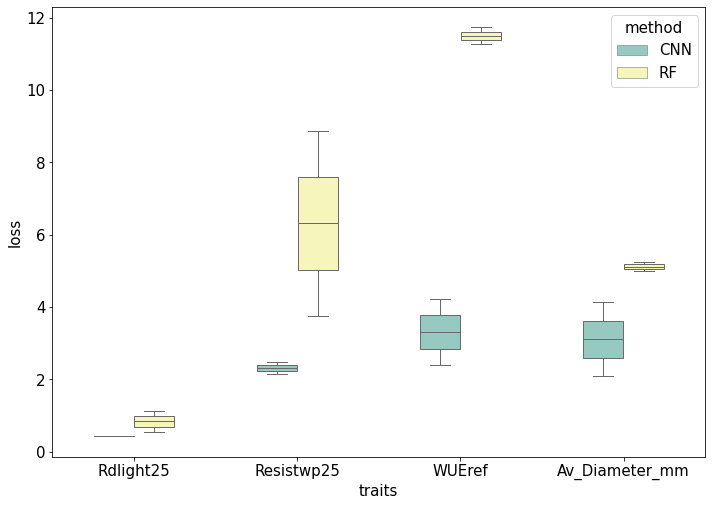

In [28]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
data_tmp1 = data[data['thresholds'] == '0.001']
sns.boxplot(x="traits", y="loss", data=data_tmp1, hue="method", width=0.5, linewidth=1.0, palette="Set3") 
#sns.boxplot(x="thresholds", y="loss", data=data, hue="traits", width=0.5, linewidth=1.0, palette="Set3") 

### Model's effect on "Jmax25" is considerably poor, thus this specific trait is not displayed on the graph.

<AxesSubplot:xlabel='traits', ylabel='loss'>

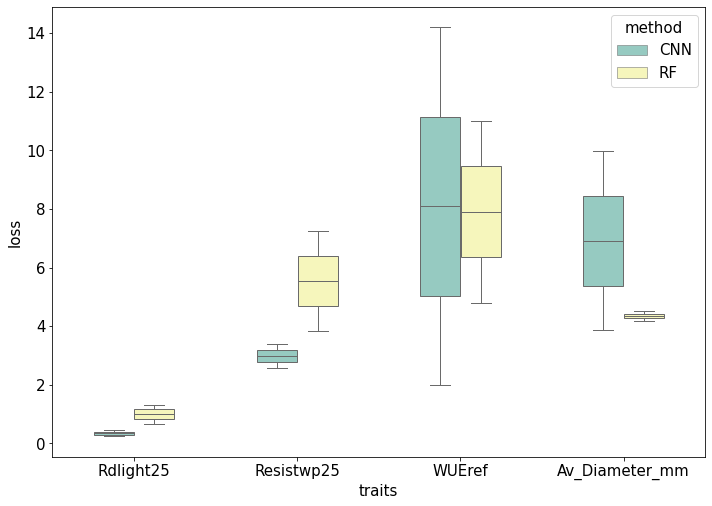

In [29]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
data_tmp1 = data[data['thresholds'] == '1e-04']
sns.boxplot(x="traits", y="loss", data=data_tmp1, hue="method", width=0.5, linewidth=1.0, palette="Set3") 
#sns.boxplot(x="thresholds", y="loss", data=data, hue="traits", width=0.5, linewidth=1.0, palette="Set3") 

<AxesSubplot:xlabel='traits', ylabel='loss'>

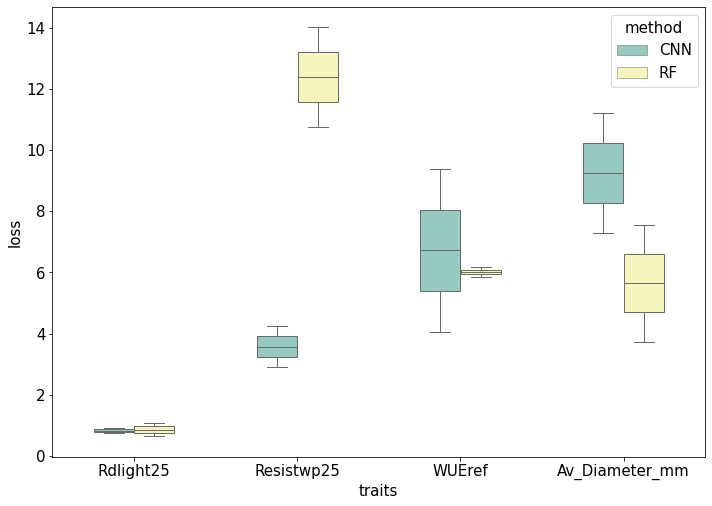

In [30]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
data_tmp1 = data[data['thresholds'] == '1e-05']
sns.boxplot(x="traits", y="loss", data=data_tmp1, hue="method", width=0.5, linewidth=1.0, palette="Set3") 
#sns.boxplot(x="thresholds", y="loss", data=data, hue="traits", width=0.5, linewidth=1.0, palette="Set3") 

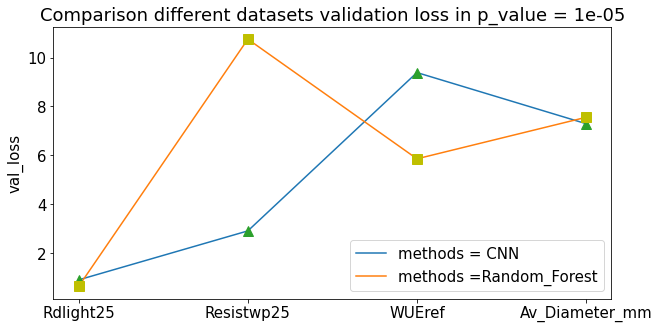

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(traits[1:],loss_list[1:5],label = 'methods = CNN')
plt.plot(traits[1:],loss_list2[1:5],label = 'methods =Random_Forest')
plt.plot(traits[1:],loss_list[1:5],'^',markersize = 10)
plt.plot(traits[1:],loss_list2[1:5],'sy',markersize = 10)
plt.ylabel('val_loss',fontsize = 15)
plt.title('Comparison different datasets validation loss in p_value = 1e-05',fontsize = 18)
plt.legend()
plt.show()

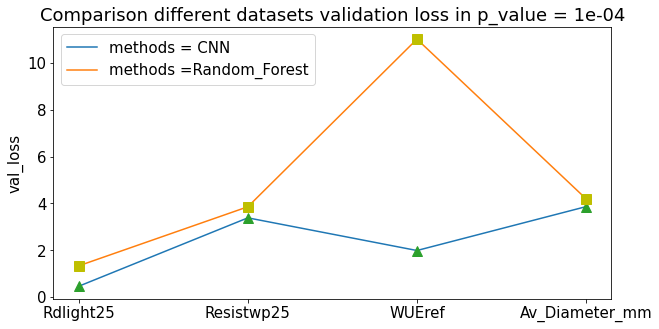

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(traits[1:],loss_list[6:10],label = 'methods = CNN')
plt.plot(traits[1:],loss_list2[6:10],label = 'methods =Random_Forest')
plt.plot(traits[1:],loss_list[6:10],'^',markersize = 10)
plt.plot(traits[1:],loss_list2[6:10],'sy',markersize = 10)
plt.ylabel('val_loss',fontsize = 15)
plt.title('Comparison different datasets validation loss in p_value = 1e-04',fontsize = 18)
plt.legend()
plt.show()

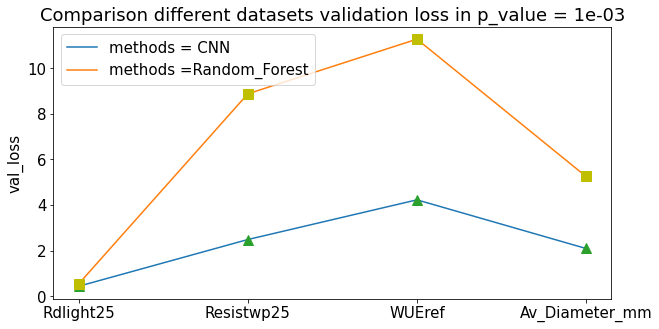

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(traits[1:],loss_list[11:15],label = 'methods = CNN')
plt.plot(traits[1:],loss_list2[11:15],label = 'methods =Random_Forest')
plt.plot(traits[1:],loss_list[11:15],'^',markersize = 10)
plt.plot(traits[1:],loss_list2[11:15],'sy',markersize = 10)
plt.ylabel('val_loss',fontsize = 15)
plt.title('Comparison different datasets validation loss in p_value = 1e-03',fontsize = 18)
plt.legend()
plt.show()

## Below lists some unused visualization. It compares different datasets validation loss in CNN under different p-values.

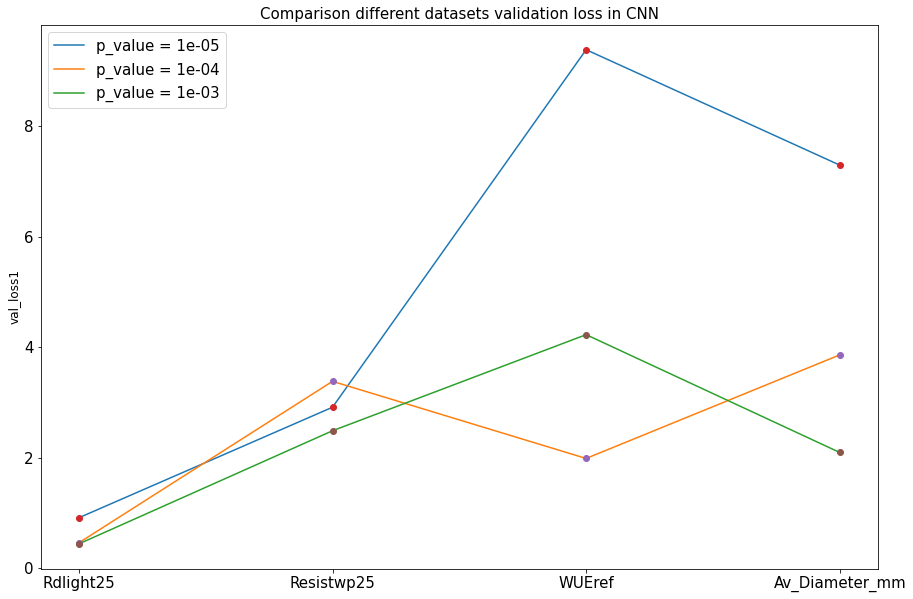

In [34]:
plt.figure(figsize=(15, 10))
plt.plot(traits[1:],loss_list[1:5],label = 'p_value = 1e-05')
plt.plot(traits[1:],loss_list[6:10],label = 'p_value = 1e-04')
plt.plot(traits[1:],loss_list[11:15],label = 'p_value = 1e-03')
plt.plot(traits[1:],loss_list[1:5],'o')
plt.plot(traits[1:],loss_list[6:10],'o')
plt.plot(traits[1:],loss_list[11:15],'o')
plt.ylabel('val_loss1',fontsize = 12)
plt.title('Comparison different datasets validation loss in CNN',fontsize = 15)
plt.legend()
plt.show()

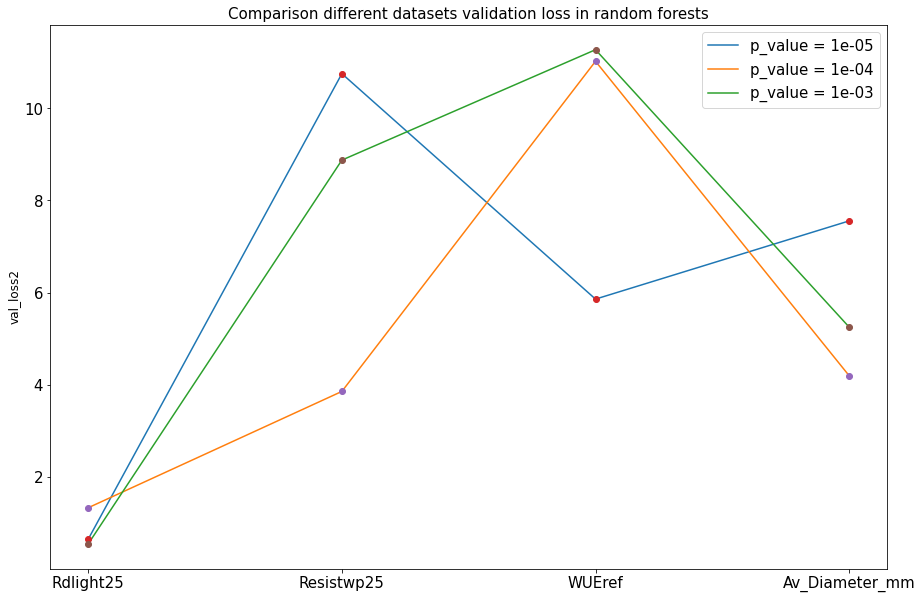

In [35]:
plt.figure(figsize=(15, 10))
plt.plot(traits[1:],loss_list2[1:5],label = 'p_value = 1e-05')
plt.plot(traits[1:],loss_list2[6:10],label = 'p_value = 1e-04')
plt.plot(traits[1:],loss_list2[11:15],label = 'p_value = 1e-03')
plt.plot(traits[1:],loss_list2[1:5],'o')
plt.plot(traits[1:],loss_list2[6:10],'o')
plt.plot(traits[1:],loss_list2[11:15],'o')
plt.ylabel('val_loss2',fontsize = 12)
plt.title('Comparison different datasets validation loss in random forests',fontsize = 15)
plt.legend()
plt.show()

# Conclusions

### 1. The performance on 'Rdilight25' datasets is competently well overall;
### 2. The smaller the p-value, the stronger stability of the model, and the better the relative comprehensive performance.

# Discussions

### 1. The possible reason for the limitation of the model is that the dataset is not sufficiently large. Theoretically speaking, the model will perform better on a large dataset.
### 2. Models like Linear Regression could also be applied to this problem.